# InforGAN

In [ ]:
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
def define_discriminator(n_cat, in_shape=(28,28,1)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=in_shape)
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.1)(d)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	d = BatchNormalization()(d)
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = LeakyReLU(alpha=0.1)(d)
	d = BatchNormalization()(d)
	d = Flatten()(d)
	out_classifier = Dense(1, activation='sigmoid')(d)
	d_model = Model(in_image, out_classifier)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	q = Dense(128)(d)
	q = BatchNormalization()(q)
	q = LeakyReLU(alpha=0.1)(q)
	out_codes = Dense(n_cat, activation='softmax')(q)
	q_model = Model(in_image, out_codes)
	return d_model, q_model

In [ ]:
def define_generator(gen_input_size):
	init = RandomNormal(stddev=0.02)
	in_lat = Input(shape=(gen_input_size,))
	n_nodes = 512 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Reshape((7, 7, 512))(gen)
	gen = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Activation('relu')(gen)
	gen = BatchNormalization()(gen)
	gen = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	model = Model(in_lat, out_layer)
	return model

In [ ]:
def define_gan(g_model, d_model, q_model):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	d_output = d_model(g_model.output)
	q_output = q_model(g_model.output)
	model = Model(g_model.input, [d_output, q_output])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model

2021-12-20 08:50:14.620722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 08:50:14.713599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 08:50:14.714363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 08:50:14.715567: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

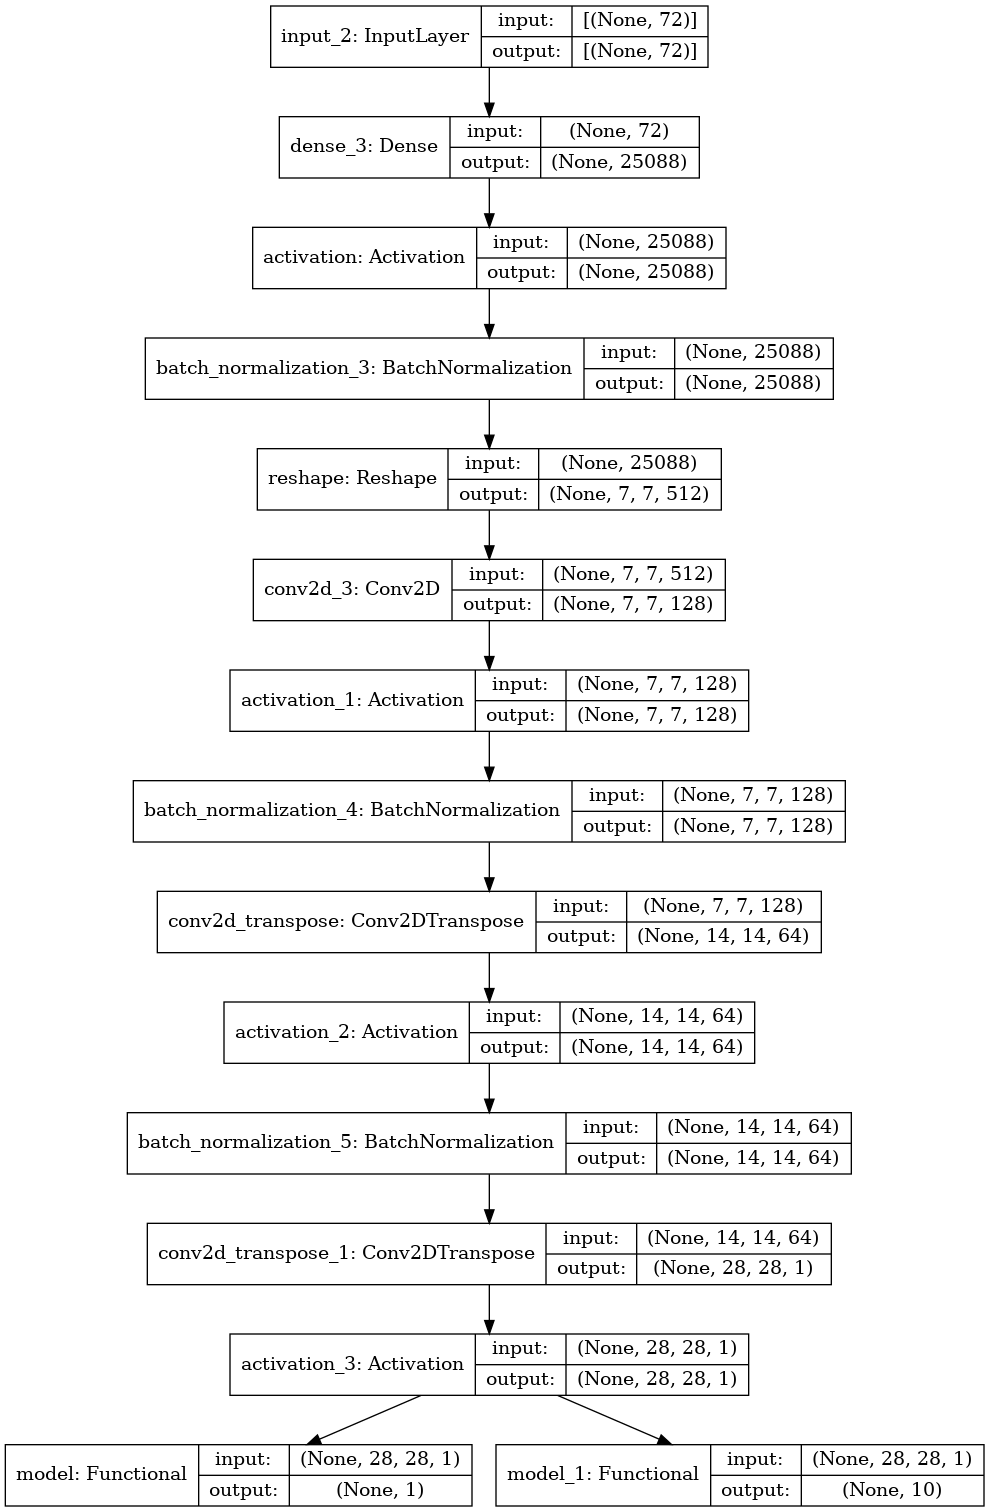

In [ ]:
n_cat = 10
latent_dim = 62
d_model, q_model = define_discriminator(n_cat)
gen_input_size = latent_dim + n_cat
g_model = define_generator(gen_input_size)
gan_model = define_gan(g_model, d_model, q_model)
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [ ]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	print(X.shape)
	return X

def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_cat, n_samples):
	z_latent = np.random.randn(latent_dim * n_samples)
	z_latent = z_latent.reshape(n_samples, latent_dim)
	cat_codes = np.random.randint(0, n_cat, n_samples)
	cat_codes = to_categorical(cat_codes, num_classes=n_cat)
	z_input = np.hstack((z_latent, cat_codes))
	return [z_input, cat_codes]

def generate_fake_samples(generator, latent_dim, n_cat, n_samples):
	z_input, _ = generate_latent_points(latent_dim, n_cat, n_samples)
	images = generator.predict(z_input)
	y = np.zeros((n_samples, 1))
	return images, y

In [ ]:
def summarize_performance(step, g_model, gan_model, latent_dim, n_cat, n_samples=100):
	X, _ = generate_fake_samples(g_model, latent_dim, n_cat, n_samples)
	X = (X + 1) / 2.0
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.show()
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	filename3 = 'gan_model_%04d.h5' % (step+1)
	gan_model.save(filename3)
	print('=> Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_cat, n_epochs=100, n_batch=64):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	for i in range(n_steps):
		X_real, y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_cat, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		z_input, cat_codes = generate_latent_points(latent_dim, n_cat, n_batch)
		y_gan = np.ones((n_batch, 1))
		_,g_1,g_2 = gan_model.train_on_batch(z_input, [y_gan, cat_codes])
		if (i+1) in (1, n_steps) or (i+1) % 100 == 0:
			print('> Step %d: d_loss[%.3f, %.3f], g[%.3f] q[%.3f]' % (i+1, d_loss1, d_loss2, g_1, g_2))
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, gan_model, latent_dim, n_cat)

In [ ]:
dataset = load_real_samples()

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


n_epochs=100, n_batch=64, 1/2=32, b/e=937, steps=93700


2021-12-20 08:50:19.130745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-20 08:50:19.998950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


> Step 1: d_loss[0.866, 0.841], g[0.502] q[2.601]


2021-12-20 08:50:33.008505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 100: d_loss[0.000, 0.000], g[0.010] q[0.085]


2021-12-20 08:50:38.787672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:50:39.321693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:50:39.406278: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:50:39.441461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 200: d_loss[0.000, 0.000], g[0.003] q[0.025]


2021-12-20 08:50:43.762302: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:50:44.030844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 300: d_loss[0.000, 0.000], g[0.002] q[0.025]
> Step 400: d_loss[0.000, 0.000], g[0.012] q[0.023]


2021-12-20 08:50:55.122271: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 500: d_loss[0.002, 0.020], g[3.938] q[0.243]
> Step 600: d_loss[0.003, 0.809], g[9.664] q[0.411]


2021-12-20 08:51:10.684127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:10.755758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:10.961408: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:11.061564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:11.152061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:11.328632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:11.552124: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 700: d_loss[1.436, 0.945], g[5.106] q[0.086]
> Step 800: d_loss[0.194, 0.173], g[3.944] q[0.074]


2021-12-20 08:51:27.814613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:28.048515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 900: d_loss[0.194, 0.242], g[4.225] q[0.101]
> Step 1000: d_loss[0.098, 0.280], g[4.366] q[0.057]


2021-12-20 08:51:42.761333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:42.839927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:43.054229: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:43.148847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:43.183153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:43.238374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:43.274074: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:51:43.419912: W tensorflow/core/data/root_dataset.cc:16

> Step 1100: d_loss[0.045, 0.045], g[3.444] q[0.100]
> Step 1200: d_loss[0.158, 0.038], g[2.643] q[0.058]
> Step 1300: d_loss[0.319, 0.455], g[3.666] q[0.085]
> Step 1400: d_loss[0.024, 0.094], g[3.818] q[0.057]


2021-12-20 08:52:11.577246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 1500: d_loss[0.164, 0.231], g[3.253] q[0.105]


2021-12-20 08:52:15.119054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:15.265010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:15.356167: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:15.391288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:15.484646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:15.539750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:18.566118: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 1600: d_loss[0.035, 0.082], g[3.677] q[0.056]


2021-12-20 08:52:22.815004: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:23.038462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 1700: d_loss[0.536, 1.734], g[6.178] q[0.140]
> Step 1800: d_loss[0.028, 0.073], g[4.535] q[0.050]


2021-12-20 08:52:33.882244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 1900: d_loss[0.431, 0.131], g[4.079] q[0.204]


2021-12-20 08:52:45.121552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:46.888906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:47.042734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 2000: d_loss[0.044, 0.076], g[4.015] q[0.111]


2021-12-20 08:52:47.130309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:47.168956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:47.293528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 2100: d_loss[0.010, 0.140], g[5.652] q[0.039]


2021-12-20 08:52:55.858111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:52:55.981370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 2200: d_loss[0.051, 0.021], g[3.220] q[0.122]


2021-12-20 08:53:06.797839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:06.862774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:06.898932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 2300: d_loss[0.190, 0.067], g[3.085] q[0.144]
> Step 2400: d_loss[0.027, 0.073], g[3.280] q[0.133]


2021-12-20 08:53:15.005522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:18.006588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:18.460882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:18.783147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:18.816972: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:18.872489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:18.962221: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:19.053380: W tensorflow/core/data/root_dataset.cc:16

> Step 2500: d_loss[0.005, 0.013], g[4.407] q[0.093]


2021-12-20 08:53:28.791482: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:28.828886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:28.885313: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 2600: d_loss[0.022, 0.006], g[3.410] q[0.038]
> Step 2700: d_loss[0.025, 0.034], g[5.085] q[0.157]
> Step 2800: d_loss[0.098, 0.064], g[4.062] q[0.073]
> Step 2900: d_loss[0.047, 0.024], g[3.969] q[0.275]


2021-12-20 08:53:49.914529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:50.761698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:51.225994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:53:51.578346: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 3000: d_loss[0.135, 0.003], g[7.958] q[0.140]
> Step 3100: d_loss[0.515, 0.375], g[2.966] q[0.120]
> Step 3200: d_loss[0.082, 0.061], g[4.508] q[0.111]


2021-12-20 08:54:12.804502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:12.929165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:13.122992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 3300: d_loss[0.010, 0.076], g[3.908] q[0.197]


2021-12-20 08:54:22.821090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:23.197939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:23.286308: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:23.463368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 3400: d_loss[0.040, 0.035], g[4.149] q[0.049]
> Step 3500: d_loss[0.150, 0.046], g[3.785] q[0.262]


2021-12-20 08:54:34.744933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:34.838077: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:34.878160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:35.072524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 3600: d_loss[0.073, 0.051], g[3.552] q[0.083]


2021-12-20 08:54:45.986558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 3700: d_loss[0.595, 0.940], g[2.816] q[0.082]
> Step 3800: d_loss[0.014, 0.045], g[3.099] q[0.109]


2021-12-20 08:54:54.558314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:54.594832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:54.923645: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:54.977697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:55.099672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:55.189414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:55.250717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:54:56.760057: W tensorflow/core/data/root_dataset.cc:16

> Step 3900: d_loss[0.035, 0.054], g[3.351] q[0.044]
> Step 4000: d_loss[0.166, 0.154], g[3.902] q[0.044]
> Step 4100: d_loss[0.163, 0.045], g[2.651] q[0.137]


2021-12-20 08:55:18.722619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:18.878536: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:18.953080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 4200: d_loss[0.488, 0.482], g[4.136] q[0.103]


2021-12-20 08:55:27.264776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.318348: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.354735: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.407377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.441257: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.499204: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.608542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:27.665181: W tensorflow/core/data/root_dataset.cc:16

> Step 4300: d_loss[0.159, 0.040], g[3.490] q[0.082]


2021-12-20 08:55:29.913924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 4400: d_loss[1.038, 2.465], g[7.077] q[0.090]


2021-12-20 08:55:40.707510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:41.042508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 4500: d_loss[0.064, 0.066], g[4.340] q[0.068]
> Step 4600: d_loss[0.072, 0.295], g[3.328] q[0.099]


2021-12-20 08:55:51.718538: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:51.790831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 4700: d_loss[0.069, 0.057], g[3.205] q[0.019]


2021-12-20 08:55:58.684370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:58.774253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:59.206255: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:59.303293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:59.336154: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:59.427952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:55:59.564571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:02.630208: W tensorflow/core/data/root_dataset.cc:16

> Step 4800: d_loss[0.044, 0.016], g[3.215] q[0.111]
> Step 4900: d_loss[0.260, 0.067], g[1.766] q[0.086]


2021-12-20 08:56:13.795534: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:14.065301: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 5000: d_loss[0.039, 0.078], g[5.145] q[0.097]
> Step 5100: d_loss[0.070, 0.029], g[3.589] q[0.131]


2021-12-20 08:56:24.830575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 5200: d_loss[0.022, 0.143], g[3.978] q[0.084]


2021-12-20 08:56:30.509801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:30.853818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:31.045406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:31.102663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:31.199797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:31.234419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:35.633591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:56:35.748333: W tensorflow/core/data/root_dataset.cc:16

> Step 5300: d_loss[0.097, 0.217], g[3.464] q[0.048]
> Step 5400: d_loss[0.067, 0.155], g[3.574] q[0.193]
> Step 5500: d_loss[0.090, 0.036], g[3.384] q[0.079]
> Step 5600: d_loss[0.214, 0.089], g[1.362] q[0.107]


2021-12-20 08:57:02.857496: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:03.253021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:03.483407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 5700: d_loss[0.174, 0.153], g[2.808] q[0.087]
> Step 5800: d_loss[0.274, 0.014], g[5.307] q[0.165]


2021-12-20 08:57:19.580787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:19.697931: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 5900: d_loss[0.020, 0.113], g[3.985] q[0.056]
> Step 6000: d_loss[0.179, 0.387], g[4.361] q[0.036]


2021-12-20 08:57:31.061547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:31.098007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6100: d_loss[0.053, 0.072], g[3.553] q[0.055]


2021-12-20 08:57:33.918531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:34.692159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:34.873418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:35.117506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:35.188676: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:35.222680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:35.432008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6200: d_loss[0.025, 0.896], g[5.518] q[0.264]


2021-12-20 08:57:41.824260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6300: d_loss[0.063, 0.147], g[3.389] q[0.060]


2021-12-20 08:57:52.619112: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:57:52.997261: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6400: d_loss[0.107, 0.228], g[3.488] q[0.162]
> Step 6500: d_loss[0.116, 0.055], g[2.518] q[0.054]


2021-12-20 08:58:03.914962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:04.132537: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:07.545045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:07.580187: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:07.667953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:07.758822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:07.815985: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6600: d_loss[0.045, 0.562], g[4.344] q[0.085]


2021-12-20 08:58:14.812620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6700: d_loss[0.079, 0.082], g[3.226] q[0.084]
> Step 6800: d_loss[0.114, 0.160], g[2.730] q[0.048]


2021-12-20 08:58:25.743726: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:25.783364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 6900: d_loss[1.152, 0.508], g[1.455] q[0.150]


2021-12-20 08:58:36.770924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:36.807948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:37.056255: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 7000: d_loss[0.485, 0.963], g[3.611] q[0.120]


2021-12-20 08:58:39.902901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:40.191661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:40.288040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:40.380976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:40.440604: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:40.476566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:40.572246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 7100: d_loss[0.125, 0.053], g[3.759] q[0.079]


2021-12-20 08:58:47.717783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:47.886064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:58:48.571784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 7200: d_loss[0.226, 0.331], g[2.796] q[0.030]


2021-12-20 08:58:58.843066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 7300: d_loss[0.073, 0.113], g[3.785] q[0.024]
> Step 7400: d_loss[0.276, 0.171], g[1.693] q[0.059]


2021-12-20 08:59:07.583145: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.330355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.390711: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.433709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.729248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.786057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.877354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:12.970907: W tensorflow/core/data/root_dataset.cc:16

> Step 7500: d_loss[0.083, 0.063], g[2.716] q[0.085]


2021-12-20 08:59:20.698544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:20.985263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:21.078638: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 7600: d_loss[0.050, 0.094], g[2.311] q[0.071]
> Step 7700: d_loss[0.041, 0.212], g[2.489] q[0.065]


2021-12-20 08:59:31.738953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:31.776753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:31.952060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:32.039733: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 7800: d_loss[0.062, 0.037], g[3.905] q[0.032]
> Step 7900: d_loss[0.287, 0.669], g[4.302] q[0.118]


2021-12-20 08:59:42.868838: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:42.903724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:45.202659: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:45.446165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:45.566420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:45.706098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:45.738779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:45.886827: W tensorflow/core/data/root_dataset.cc:16

> Step 8000: d_loss[0.308, 0.088], g[3.136] q[0.091]


2021-12-20 08:59:53.738433: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 08:59:53.777061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 8100: d_loss[0.263, 0.341], g[1.827] q[0.041]
> Step 8200: d_loss[0.095, 0.048], g[3.077] q[0.134]


2021-12-20 09:00:04.784514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:04.841581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:04.875091: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 8300: d_loss[0.390, 0.358], g[3.098] q[0.148]


2021-12-20 09:00:15.614216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:15.837595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:16.067758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:16.115912: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 8400: d_loss[0.103, 0.058], g[3.164] q[0.067]


2021-12-20 09:00:18.273147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.528858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.594060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.627804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.718648: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.774216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.807340: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:18.863481: W tensorflow/core/data/root_dataset.cc:16

> Step 8500: d_loss[0.188, 0.222], g[2.247] q[0.067]


2021-12-20 09:00:26.791133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:26.824945: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 8600: d_loss[0.425, 0.350], g[2.008] q[0.007]
> Step 8700: d_loss[0.868, 0.523], g[1.833] q[0.094]
> Step 8800: d_loss[0.101, 0.730], g[2.579] q[0.076]


2021-12-20 09:00:51.514052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:51.553296: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:51.661637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 8900: d_loss[0.214, 0.178], g[3.163] q[0.094]
> Step 9000: d_loss[0.509, 0.205], g[2.741] q[0.144]


2021-12-20 09:00:59.817434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:00:59.884732: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 9100: d_loss[0.228, 0.897], g[3.347] q[0.159]


2021-12-20 09:01:10.748996: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 9200: d_loss[0.148, 0.103], g[2.796] q[0.021]
> Step 9300: d_loss[0.487, 0.199], g[2.277] q[0.098]


2021-12-20 09:01:21.820307: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:22.054523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:24.048037: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:24.083693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:24.189969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:24.250491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:24.449841: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:24.486872: W tensorflow/core/data/root_dataset.cc:16

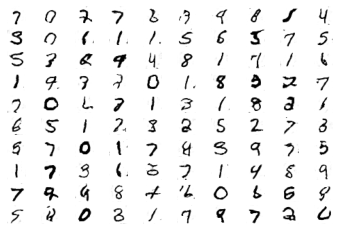

=> Saved: generated_plot_9370.png, model_9370.h5, and gan_model_9370.h5
> Step 9400: d_loss[0.402, 0.392], g[0.931] q[0.064]


2021-12-20 09:01:32.737342: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:32.886520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 9500: d_loss[0.455, 0.450], g[2.168] q[0.053]


2021-12-20 09:01:43.832797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 9600: d_loss[0.183, 0.324], g[2.655] q[0.021]
> Step 9700: d_loss[0.564, 0.525], g[2.010] q[0.069]


2021-12-20 09:01:55.030548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:55.123529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:55.322936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:58.111304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:58.176434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:58.214671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:58.466382: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:01:58.562117: W tensorflow/core/data/root_dataset.cc:16

> Step 9800: d_loss[0.096, 0.385], g[1.875] q[0.070]


2021-12-20 09:02:03.247590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 9900: d_loss[0.252, 0.350], g[1.389] q[0.033]


2021-12-20 09:02:05.953918: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 10000: d_loss[0.583, 0.209], g[1.250] q[0.080]


2021-12-20 09:02:16.735902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:16.772927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:16.833116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:16.867046: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 10100: d_loss[0.206, 0.175], g[1.740] q[0.046]
> Step 10200: d_loss[0.241, 0.176], g[1.338] q[0.071]


2021-12-20 09:02:25.785156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:27.764576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:30.353133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:30.393782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:30.460291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:30.555487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:30.657908: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:30.856604: W tensorflow/core/data/root_dataset.cc:16

> Step 10300: d_loss[0.501, 0.337], g[2.219] q[0.077]


2021-12-20 09:02:38.770519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:02:38.980543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 10400: d_loss[0.401, 0.222], g[1.398] q[0.027]
> Step 10500: d_loss[0.399, 0.125], g[1.699] q[0.099]


2021-12-20 09:02:50.074855: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 10600: d_loss[0.243, 0.284], g[2.058] q[0.121]
> Step 10700: d_loss[0.115, 0.193], g[1.748] q[0.031]


2021-12-20 09:02:59.931270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:01.066520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:03.381491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:03.419339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:03.473581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:03.562715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:03.600656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:03.724599: W tensorflow/core/data/root_dataset.cc:16

> Step 10800: d_loss[0.133, 0.310], g[2.268] q[0.047]


2021-12-20 09:03:11.769007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:11.845013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 10900: d_loss[0.402, 0.237], g[2.486] q[0.120]
> Step 11000: d_loss[0.162, 0.845], g[2.841] q[0.014]


2021-12-20 09:03:22.919527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:23.113983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 11100: d_loss[0.699, 0.523], g[1.919] q[0.089]


2021-12-20 09:03:33.664109: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:33.771524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:33.862521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 11200: d_loss[0.321, 0.576], g[1.988] q[0.020]


2021-12-20 09:03:36.504634: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.619005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.729707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.763326: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.819311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.909780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.943523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:03:36.995756: W tensorflow/core/data/root_dataset.cc:16

> Step 11300: d_loss[0.212, 0.208], g[2.322] q[0.053]
> Step 11400: d_loss[0.504, 0.501], g[1.938] q[0.012]
> Step 11500: d_loss[0.186, 0.288], g[2.478] q[0.103]


2021-12-20 09:03:56.021537: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 11600: d_loss[0.161, 0.135], g[1.979] q[0.046]


2021-12-20 09:04:06.758756: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:06.793546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:07.005230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 11700: d_loss[0.622, 0.435], g[1.166] q[0.026]


2021-12-20 09:04:09.279944: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:09.501023: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:09.587261: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:09.676251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:09.814567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 11800: d_loss[0.254, 0.155], g[2.105] q[0.013]


2021-12-20 09:04:18.115691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 11900: d_loss[0.389, 0.374], g[2.398] q[0.005]
> Step 12000: d_loss[0.113, 0.301], g[2.113] q[0.073]
> Step 12100: d_loss[0.482, 0.455], g[1.380] q[0.024]


2021-12-20 09:04:41.946398: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.062449: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.097663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.578359: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.663014: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.713787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.746779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:42.812410: W tensorflow/core/data/root_dataset.cc:16

> Step 12200: d_loss[0.141, 0.342], g[2.461] q[0.087]
> Step 12300: d_loss[0.114, 0.885], g[2.035] q[0.067]


2021-12-20 09:04:50.942718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:04:51.073516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 12400: d_loss[0.235, 0.310], g[2.575] q[0.071]


2021-12-20 09:05:01.629422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:01.960520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:02.021395: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 12500: d_loss[0.036, 0.232], g[3.331] q[0.050]
> Step 12600: d_loss[0.147, 0.092], g[2.654] q[0.077]


2021-12-20 09:05:15.396032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:15.465183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:15.498687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:15.553650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:15.877016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 12700: d_loss[0.045, 0.106], g[1.768] q[0.080]


2021-12-20 09:05:24.013183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 12800: d_loss[0.409, 0.094], g[1.719] q[0.004]
> Step 12900: d_loss[0.134, 0.591], g[3.324] q[0.064]


2021-12-20 09:05:34.937516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:35.043519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 13000: d_loss[0.092, 0.190], g[1.747] q[0.043]
> Step 13100: d_loss[0.251, 0.124], g[1.694] q[0.007]


2021-12-20 09:05:47.957639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.059711: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.152266: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.195769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.409448: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.509144: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.609911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:05:48.653941: W tensorflow/core/data/root_dataset.cc:16

> Step 13200: d_loss[0.137, 0.294], g[2.978] q[0.008]
> Step 13300: d_loss[0.731, 0.697], g[2.793] q[0.008]
> Step 13400: d_loss[0.201, 0.618], g[2.651] q[0.028]
> Step 13500: d_loss[0.198, 0.244], g[2.453] q[0.069]


2021-12-20 09:06:18.586206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:18.637837: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:18.756577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:18.960492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:18.995098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:19.159008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:21.188351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:21.558673: W tensorflow/core/data/root_dataset.cc:16

> Step 13600: d_loss[0.173, 0.227], g[3.136] q[0.043]


2021-12-20 09:06:21.794605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:21.828022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:21.971651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:22.061736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 13700: d_loss[0.047, 0.197], g[2.265] q[0.094]


2021-12-20 09:06:29.591852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:29.777006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:29.814277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:29.969519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 13800: d_loss[0.158, 0.216], g[2.362] q[0.055]


2021-12-20 09:06:40.796269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 13900: d_loss[0.471, 0.298], g[1.844] q[0.057]
> Step 14000: d_loss[0.614, 0.213], g[1.329] q[0.013]


2021-12-20 09:06:49.835663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:51.811486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:51.986831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:52.133666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:54.013774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:54.151002: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:54.186360: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:06:54.725329: W tensorflow/core/data/root_dataset.cc:16

> Step 14100: d_loss[0.569, 0.415], g[1.510] q[0.037]


2021-12-20 09:07:02.769808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:02.806995: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:02.862732: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:02.898562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 14200: d_loss[0.184, 0.474], g[1.757] q[0.071]
> Step 14300: d_loss[0.252, 0.107], g[2.412] q[0.006]


2021-12-20 09:07:13.753660: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:14.061040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 14400: d_loss[0.071, 0.464], g[2.015] q[0.019]
> Step 14500: d_loss[0.437, 0.609], g[1.732] q[0.024]


2021-12-20 09:07:27.415151: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:27.681116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:27.786567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:27.933827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:27.993065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:28.093655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:28.193150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 14600: d_loss[0.124, 0.264], g[3.096] q[0.003]
> Step 14700: d_loss[0.825, 0.959], g[1.321] q[0.007]
> Step 14800: d_loss[0.211, 0.233], g[1.837] q[0.104]


2021-12-20 09:07:46.742865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:07:46.829686: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 14900: d_loss[0.180, 0.460], g[2.600] q[0.029]


2021-12-20 09:07:57.879745: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 15000: d_loss[0.698, 0.169], g[1.238] q[0.011]


2021-12-20 09:08:00.637922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:00.697263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:01.079078: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:01.166908: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:01.201423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:01.256044: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:01.351387: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:01.387351: W tensorflow/core/data/root_dataset.cc:16

> Step 15100: d_loss[0.148, 0.295], g[2.765] q[0.052]


2021-12-20 09:08:08.634288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:08.855315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:08.915306: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:08.948709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 15200: d_loss[0.405, 0.141], g[1.528] q[0.038]
> Step 15300: d_loss[0.373, 0.370], g[2.368] q[0.038]
> Step 15400: d_loss[0.319, 0.257], g[2.022] q[0.035]
> Step 15500: d_loss[0.222, 0.142], g[1.849] q[0.078]


2021-12-20 09:08:33.505427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:33.811965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:33.845280: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:33.897661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:33.930020: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:34.119614: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:34.205131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:34.266115: W tensorflow/core/data/root_dataset.cc:16

> Step 15600: d_loss[0.128, 0.169], g[3.811] q[0.115]
> Step 15700: d_loss[0.110, 0.301], g[2.653] q[0.094]
> Step 15800: d_loss[0.353, 1.157], g[3.540] q[0.079]


2021-12-20 09:08:52.755562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:52.815067: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:52.850161: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:08:52.915206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 15900: d_loss[2.222, 0.333], g[1.271] q[0.048]


2021-12-20 09:09:06.766709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 16000: d_loss[0.126, 0.300], g[2.468] q[0.096]


2021-12-20 09:09:06.998515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:07.222568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 16100: d_loss[0.813, 0.070], g[2.583] q[0.032]
> Step 16200: d_loss[0.568, 0.377], g[1.641] q[0.017]


2021-12-20 09:09:25.653200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 16300: d_loss[0.190, 0.545], g[3.216] q[0.046]
> Step 16400: d_loss[0.400, 0.547], g[1.529] q[0.054]


2021-12-20 09:09:36.834315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:36.922410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:37.011111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:37.106059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:39.217390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:39.251583: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:39.307335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:39.471558: W tensorflow/core/data/root_dataset.cc:16

> Step 16500: d_loss[0.143, 0.051], g[1.366] q[0.083]
> Step 16600: d_loss[0.102, 0.366], g[1.818] q[0.084]


2021-12-20 09:09:47.770179: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:09:47.896515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 16700: d_loss[0.215, 0.148], g[2.805] q[0.122]
> Step 16800: d_loss[1.326, 0.728], g[0.730] q[0.013]
> Step 16900: d_loss[0.441, 0.518], g[2.623] q[0.054]


2021-12-20 09:10:09.574088: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:10.033515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:10.299875: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:12.310456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:12.377410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:12.820625: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:12.881778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:12.914567: W tensorflow/core/data/root_dataset.cc:16

> Step 17000: d_loss[0.168, 0.681], g[2.083] q[0.039]


2021-12-20 09:10:20.908236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 17100: d_loss[0.479, 0.746], g[2.936] q[0.011]
> Step 17200: d_loss[0.243, 0.300], g[1.963] q[0.025]


2021-12-20 09:10:31.575444: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:31.755647: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:31.817588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 17300: d_loss[0.327, 0.917], g[1.722] q[0.066]


2021-12-20 09:10:42.582184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:43.012528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 17400: d_loss[0.147, 0.710], g[2.520] q[0.016]


2021-12-20 09:10:46.547621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.082408: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.142498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.177006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.267685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.361218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.415965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:10:47.505603: W tensorflow/core/data/root_dataset.cc:16

> Step 17500: d_loss[0.073, 0.082], g[3.159] q[0.034]


2021-12-20 09:10:53.622621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 17600: d_loss[0.229, 0.247], g[1.446] q[0.028]


2021-12-20 09:11:04.733905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:04.832126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 17700: d_loss[0.291, 0.494], g[1.682] q[0.027]
> Step 17800: d_loss[0.332, 0.043], g[1.633] q[0.018]


2021-12-20 09:11:15.747195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:15.810794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:16.034601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:16.081762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:18.476080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:18.585449: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:18.803798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:18.918384: W tensorflow/core/data/root_dataset.cc:16

> Step 17900: d_loss[0.664, 0.338], g[1.298] q[0.120]
> Step 18000: d_loss[0.281, 0.084], g[1.402] q[0.140]


2021-12-20 09:11:26.583627: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:26.983524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 18100: d_loss[0.272, 0.424], g[2.524] q[0.024]
> Step 18200: d_loss[0.268, 0.417], g[1.637] q[0.027]
> Step 18300: d_loss[0.305, 0.284], g[2.618] q[0.037]


2021-12-20 09:11:47.379525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:48.832533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:49.108223: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:52.669825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:52.774636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:52.842502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:52.937257: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:11:53.175256: W tensorflow/core/data/root_dataset.cc:16

> Step 18400: d_loss[0.487, 0.644], g[2.547] q[0.043]
> Step 18500: d_loss[0.181, 0.165], g[1.925] q[0.022]
> Step 18600: d_loss[0.759, 0.937], g[1.605] q[0.044]
> Step 18700: d_loss[0.567, 0.381], g[2.295] q[0.086]


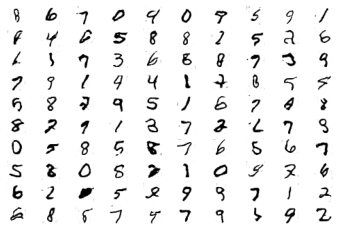

=> Saved: generated_plot_18740.png, model_18740.h5, and gan_model_18740.h5


2021-12-20 09:12:24.528314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:24.629511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:24.851493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:24.910362: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:24.993159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:25.117087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:25.170952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:25.290014: W tensorflow/core/data/root_dataset.cc:16

> Step 18800: d_loss[0.376, 0.403], g[1.272] q[0.104]


2021-12-20 09:12:32.584344: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:32.794193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:33.081734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 18900: d_loss[0.347, 0.178], g[1.114] q[0.003]
> Step 19000: d_loss[0.799, 0.227], g[1.082] q[0.021]
> Step 19100: d_loss[0.102, 0.322], g[1.926] q[0.036]
> Step 19200: d_loss[0.058, 0.145], g[2.017] q[0.041]


2021-12-20 09:12:53.405223: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:53.495684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:54.774811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:54.825864: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:54.942671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:56.841884: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:57.261147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:12:57.302079: W tensorflow/core/data/root_dataset.cc:16

> Step 19300: d_loss[0.268, 0.717], g[2.527] q[0.149]
> Step 19400: d_loss[0.459, 0.215], g[2.249] q[0.007]
> Step 19500: d_loss[0.195, 0.361], g[1.874] q[0.006]


2021-12-20 09:13:16.791522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:17.055518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 19600: d_loss[0.383, 0.385], g[2.324] q[0.006]
> Step 19700: d_loss[0.461, 0.766], g[2.405] q[0.083]


2021-12-20 09:13:27.767432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:28.071529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:29.084338: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:29.180348: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:29.239982: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:29.461141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:29.553354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:13:29.645568: W tensorflow/core/data/root_dataset.cc:16

> Step 19800: d_loss[0.194, 0.313], g[2.778] q[0.043]


2021-12-20 09:13:39.116511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 19900: d_loss[0.281, 0.390], g[2.265] q[0.020]
> Step 20000: d_loss[0.112, 0.623], g[2.119] q[0.037]


2021-12-20 09:13:49.633599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 20100: d_loss[0.614, 0.765], g[1.623] q[0.008]


2021-12-20 09:14:01.051957: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:01.104526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:01.780617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:01.844588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 20200: d_loss[1.433, 0.826], g[1.413] q[0.005]
> Step 20300: d_loss[0.158, 0.165], g[1.810] q[0.050]
> Step 20400: d_loss[0.571, 0.492], g[2.349] q[0.085]
> Step 20500: d_loss[0.297, 0.416], g[1.877] q[0.061]


2021-12-20 09:14:22.679417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 20600: d_loss[0.327, 0.170], g[2.120] q[0.101]


2021-12-20 09:14:33.242456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:33.403127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:33.541651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:33.595869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:34.507185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 20700: d_loss[0.597, 0.336], g[1.602] q[0.023]
> Step 20800: d_loss[0.292, 0.223], g[1.853] q[0.010]
> Step 20900: d_loss[0.411, 0.385], g[1.801] q[0.086]


2021-12-20 09:14:56.047836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:14:56.140056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 21000: d_loss[0.672, 0.268], g[1.892] q[0.019]
> Step 21100: d_loss[0.495, 0.415], g[1.842] q[0.072]


2021-12-20 09:15:06.956522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:07.333374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:07.464146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:07.583952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:08.098821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:08.132999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:08.279343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:08.315898: W tensorflow/core/data/root_dataset.cc:16

> Step 21200: d_loss[0.994, 0.331], g[0.960] q[0.053]
> Step 21300: d_loss[0.711, 0.507], g[1.622] q[0.012]


2021-12-20 09:15:17.770114: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:17.825563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:17.858713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:18.092073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 21400: d_loss[0.283, 0.150], g[1.321] q[0.049]
> Step 21500: d_loss[0.950, 0.444], g[2.027] q[0.039]
> Step 21600: d_loss[0.541, 0.759], g[1.497] q[0.058]


2021-12-20 09:15:39.659234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:39.788739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:39.865942: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:40.018214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:40.186262: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:40.386222: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:40.445695: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 21700: d_loss[0.329, 0.706], g[2.113] q[0.048]


2021-12-20 09:15:50.900441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:50.935569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:50.995348: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:51.031718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:15:51.092286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 21800: d_loss[0.163, 0.459], g[2.642] q[0.014]
> Step 21900: d_loss[0.215, 0.363], g[2.846] q[0.014]
> Step 22000: d_loss[0.966, 0.237], g[0.581] q[0.043]


2021-12-20 09:16:12.233539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:12.371999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:12.494921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:13.251096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:13.409909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 22100: d_loss[0.117, 0.569], g[2.181] q[0.011]
> Step 22200: d_loss[0.189, 0.208], g[1.420] q[0.048]


2021-12-20 09:16:23.827887: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:23.888832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:24.111562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 22300: d_loss[0.358, 1.028], g[1.655] q[0.056]


2021-12-20 09:16:34.789450: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:34.823075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:35.077140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 22400: d_loss[0.665, 0.348], g[1.764] q[0.072]
> Step 22500: d_loss[0.265, 0.243], g[2.110] q[0.023]


2021-12-20 09:16:44.843792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:44.939283: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:45.007295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:45.044031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:45.213527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:45.369025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:45.530939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 22600: d_loss[0.601, 0.367], g[1.158] q[0.041]


2021-12-20 09:16:56.574237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:16:56.749084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 22700: d_loss[0.186, 0.154], g[1.409] q[0.004]
> Step 22800: d_loss[0.547, 0.236], g[1.543] q[0.032]


2021-12-20 09:17:07.787317: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 22900: d_loss[0.375, 1.248], g[2.800] q[0.081]
> Step 23000: d_loss[1.045, 0.597], g[1.766] q[0.038]


2021-12-20 09:17:17.823531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:17.988784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:18.204831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:18.357790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:18.447898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:18.535273: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 23100: d_loss[0.447, 0.669], g[1.865] q[0.092]


2021-12-20 09:17:29.718997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 23200: d_loss[0.278, 0.369], g[2.563] q[0.060]
> Step 23300: d_loss[0.446, 0.270], g[0.817] q[0.049]


2021-12-20 09:17:40.690543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:40.864978: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:41.078185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 23400: d_loss[0.757, 0.344], g[0.943] q[0.083]


2021-12-20 09:17:50.992552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:51.211519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:51.367529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:51.411669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:51.593533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:51.653558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:51.783025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:17:52.088111: W tensorflow/core/data/root_dataset.cc:16

> Step 23500: d_loss[0.159, 0.325], g[2.436] q[0.041]
> Step 23600: d_loss[0.988, 0.531], g[1.635] q[0.022]


2021-12-20 09:18:02.782556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 23700: d_loss[0.336, 0.461], g[2.380] q[0.050]
> Step 23800: d_loss[0.450, 0.256], g[2.338] q[0.024]
> Step 23900: d_loss[0.250, 0.862], g[2.152] q[0.004]


2021-12-20 09:18:24.433663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:18:24.488886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:18:24.521687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:18:25.108540: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:18:25.257389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24000: d_loss[0.339, 0.338], g[2.452] q[0.015]


2021-12-20 09:18:35.850518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24100: d_loss[0.241, 0.249], g[1.382] q[0.023]
> Step 24200: d_loss[0.783, 0.350], g[1.247] q[0.041]


2021-12-20 09:18:46.898121: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24300: d_loss[0.276, 0.226], g[2.183] q[0.044]


2021-12-20 09:18:56.861924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:18:57.468711: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:18:57.518510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24400: d_loss[0.175, 0.160], g[2.564] q[0.023]
> Step 24500: d_loss[0.255, 0.171], g[1.472] q[0.009]


2021-12-20 09:19:08.812922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24600: d_loss[0.678, 0.207], g[2.205] q[0.038]


2021-12-20 09:19:20.041314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:20.079541: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24700: d_loss[0.282, 0.600], g[1.687] q[0.048]


2021-12-20 09:19:28.778287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:28.920564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:29.470247: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24800: d_loss[0.580, 0.379], g[1.030] q[0.043]


2021-12-20 09:19:30.588592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:30.807506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:31.051517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 24900: d_loss[0.370, 1.820], g[1.533] q[0.020]


2021-12-20 09:19:41.804110: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:42.062034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 25000: d_loss[0.536, 0.248], g[2.384] q[0.030]
> Step 25100: d_loss[0.855, 0.370], g[2.060] q[0.042]


2021-12-20 09:19:52.789935: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:19:52.968184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 25200: d_loss[0.126, 0.661], g[1.644] q[0.011]


2021-12-20 09:20:00.442758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:00.482109: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:00.684246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:01.168355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:01.290618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 25300: d_loss[0.406, 0.947], g[2.704] q[0.008]
> Step 25400: d_loss[0.636, 1.215], g[1.627] q[0.049]


2021-12-20 09:20:14.679251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:14.750457: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:14.861792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 25500: d_loss[0.190, 0.395], g[2.708] q[0.006]
> Step 25600: d_loss[0.815, 0.427], g[1.712] q[0.078]


2021-12-20 09:20:25.702339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:26.086234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 25700: d_loss[0.391, 0.302], g[1.516] q[0.017]


2021-12-20 09:20:32.050693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:32.947096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:33.196269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:33.383688: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:33.422305: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:33.473083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:33.507001: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:33.661595: W tensorflow/core/data/root_dataset.cc:16

> Step 25800: d_loss[0.406, 0.668], g[1.652] q[0.034]
> Step 25900: d_loss[0.148, 0.244], g[3.104] q[0.125]


2021-12-20 09:20:47.688646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:47.831323: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26000: d_loss[0.162, 0.502], g[1.613] q[0.009]


2021-12-20 09:20:58.580526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:58.785530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:20:59.100519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26100: d_loss[0.192, 0.213], g[1.937] q[0.033]
> Step 26200: d_loss[0.282, 1.704], g[1.701] q[0.022]


2021-12-20 09:21:05.939112: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.058407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.173531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.355842: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.411751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.602618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.697140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:06.729744: W tensorflow/core/data/root_dataset.cc:16

> Step 26300: d_loss[0.352, 0.822], g[1.530] q[0.030]
> Step 26400: d_loss[0.864, 0.849], g[1.479] q[0.011]


2021-12-20 09:21:21.113318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26500: d_loss[0.221, 0.579], g[2.174] q[0.076]


2021-12-20 09:21:32.100648: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26600: d_loss[0.346, 0.127], g[1.795] q[0.112]


2021-12-20 09:21:39.048442: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:39.282021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:39.761672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:39.964849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26700: d_loss[0.494, 0.690], g[2.385] q[0.062]


2021-12-20 09:21:40.050615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:42.665827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26800: d_loss[0.634, 0.413], g[1.653] q[0.005]


2021-12-20 09:21:53.738561: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:21:53.806747: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 26900: d_loss[0.598, 0.430], g[1.852] q[0.006]
> Step 27000: d_loss[0.466, 0.068], g[2.241] q[0.013]


2021-12-20 09:22:04.868677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:22:05.030999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27100: d_loss[0.311, 0.274], g[2.119] q[0.011]


2021-12-20 09:22:12.066980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27200: d_loss[0.613, 0.435], g[1.816] q[0.006]


2021-12-20 09:22:15.922509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:22:16.105224: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27300: d_loss[0.382, 0.343], g[2.810] q[0.010]
> Step 27400: d_loss[0.756, 0.818], g[1.811] q[0.022]
> Step 27500: d_loss[0.768, 0.450], g[2.037] q[0.030]


2021-12-20 09:22:37.782322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:22:37.928523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27600: d_loss[0.705, 0.318], g[1.795] q[0.022]


2021-12-20 09:22:45.304665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:22:45.423010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27700: d_loss[0.068, 0.429], g[2.352] q[0.069]


2021-12-20 09:22:48.830004: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27800: d_loss[0.313, 0.326], g[1.952] q[0.064]


2021-12-20 09:22:59.964049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:00.094882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 27900: d_loss[0.549, 0.098], g[1.656] q[0.067]
> Step 28000: d_loss[0.404, 0.256], g[1.326] q[0.019]


2021-12-20 09:23:10.775834: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:10.817209: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 28100: d_loss[0.282, 0.568], g[2.556] q[0.017]


2021-12-20 09:23:16.135637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


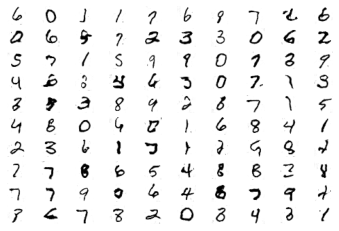

=> Saved: generated_plot_28110.png, model_28110.h5, and gan_model_28110.h5
> Step 28200: d_loss[0.343, 0.641], g[1.589] q[0.050]


2021-12-20 09:23:33.044775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 28300: d_loss[0.354, 1.258], g[1.939] q[0.051]
> Step 28400: d_loss[0.223, 0.346], g[2.376] q[0.009]


2021-12-20 09:23:43.993029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 28500: d_loss[0.877, 0.239], g[1.198] q[0.025]


2021-12-20 09:23:50.973748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.109849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.166552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.321416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.414530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.555160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.587420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:23:51.637621: W tensorflow/core/data/root_dataset.cc:16

> Step 28600: d_loss[0.170, 0.249], g[2.435] q[0.102]


2021-12-20 09:23:54.777525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 28700: d_loss[0.968, 0.499], g[0.735] q[0.036]


2021-12-20 09:24:06.025230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:06.058918: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 28800: d_loss[0.680, 0.379], g[1.319] q[0.006]
> Step 28900: d_loss[0.041, 0.323], g[1.739] q[0.048]
> Step 29000: d_loss[0.243, 0.669], g[1.861] q[0.055]


2021-12-20 09:24:20.820379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:20.874269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:22.803188: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:22.998492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:23.243681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:23.435738: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 29100: d_loss[0.395, 0.411], g[2.560] q[0.094]


2021-12-20 09:24:27.672814: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:27.754172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:27.820186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:27.852576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 29200: d_loss[0.106, 0.293], g[1.434] q[0.010]


2021-12-20 09:24:38.581697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:38.802924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:38.841162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:38.912184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:38.948548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 29300: d_loss[0.092, 0.179], g[2.318] q[0.036]
> Step 29400: d_loss[0.748, 0.264], g[1.098] q[0.019]


2021-12-20 09:24:54.528874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:54.562023: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:54.631380: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:24:54.950686: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 29500: d_loss[0.291, 1.211], g[1.732] q[0.034]


2021-12-20 09:25:00.754673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 29600: d_loss[0.586, 0.233], g[1.429] q[0.010]
> Step 29700: d_loss[0.779, 0.703], g[1.140] q[0.034]


2021-12-20 09:25:11.643782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:11.753517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 29800: d_loss[0.507, 0.337], g[1.190] q[0.010]
> Step 29900: d_loss[0.249, 0.841], g[2.379] q[0.028]


2021-12-20 09:25:23.135408: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:26.922155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:26.984942: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:27.023340: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:27.284331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:27.394522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:27.445705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:27.548715: W tensorflow/core/data/root_dataset.cc:16

> Step 30000: d_loss[0.191, 0.299], g[2.297] q[0.090]


2021-12-20 09:25:33.687082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:34.058822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 30100: d_loss[0.528, 0.906], g[1.704] q[0.012]
> Step 30200: d_loss[0.495, 0.332], g[1.681] q[0.016]
> Step 30300: d_loss[0.167, 0.377], g[2.188] q[0.099]
> Step 30400: d_loss[0.189, 0.889], g[2.316] q[0.011]


2021-12-20 09:25:59.333808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:59.369802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:59.426258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:59.461244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:25:59.516874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 30500: d_loss[0.137, 0.996], g[2.121] q[0.028]


2021-12-20 09:26:06.590983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:06.842680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 30600: d_loss[0.214, 0.281], g[1.734] q[0.047]


2021-12-20 09:26:18.039012: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 30700: d_loss[0.273, 0.107], g[1.699] q[0.015]
> Step 30800: d_loss[0.541, 0.638], g[0.997] q[0.153]


2021-12-20 09:26:28.624461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:28.667974: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:28.859611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:29.112526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:30.286581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:30.425815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:30.492166: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:30.543252: W tensorflow/core/data/root_dataset.cc:16

> Step 30900: d_loss[0.217, 0.530], g[1.554] q[0.023]


2021-12-20 09:26:39.752582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:39.877518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:26:39.934595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 31000: d_loss[0.470, 0.113], g[2.192] q[0.011]
> Step 31100: d_loss[0.998, 0.461], g[1.531] q[0.060]


2021-12-20 09:26:51.046207: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 31200: d_loss[0.672, 0.401], g[1.611] q[0.060]


2021-12-20 09:27:01.826210: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 31300: d_loss[0.497, 0.596], g[1.658] q[0.010]


2021-12-20 09:27:03.100451: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.415805: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.504456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.561533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.594750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.657929: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.693140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:03.750132: W tensorflow/core/data/root_dataset.cc:16

> Step 31400: d_loss[0.539, 0.365], g[2.061] q[0.018]


2021-12-20 09:27:12.904044: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:12.995668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 31500: d_loss[0.899, 0.518], g[1.626] q[0.013]
> Step 31600: d_loss[0.273, 0.268], g[1.790] q[0.027]


2021-12-20 09:27:23.678452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:24.022925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 31700: d_loss[0.368, 0.228], g[1.846] q[0.031]


2021-12-20 09:27:35.475533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:35.619725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:27:36.073020: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 31800: d_loss[0.713, 0.826], g[1.846] q[0.038]
> Step 31900: d_loss[0.331, 0.400], g[1.590] q[0.008]
> Step 32000: d_loss[1.140, 0.524], g[0.998] q[0.026]


2021-12-20 09:27:56.813718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 32100: d_loss[0.193, 0.233], g[1.287] q[0.055]
> Step 32200: d_loss[0.592, 0.336], g[1.021] q[0.011]


2021-12-20 09:28:06.614248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:06.683514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:06.978720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:07.110244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:07.234392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:07.304152: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 32300: d_loss[0.547, 0.396], g[1.438] q[0.007]


2021-12-20 09:28:18.744917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:19.061507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 32400: d_loss[0.375, 1.273], g[1.799] q[0.009]
> Step 32500: d_loss[0.576, 1.026], g[2.062] q[0.013]
> Step 32600: d_loss[0.797, 0.324], g[1.294] q[0.007]


2021-12-20 09:28:38.878029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:39.074071: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:39.230576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:40.896340: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:40.932381: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:28:41.120427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 32700: d_loss[0.717, 0.576], g[1.503] q[0.019]
> Step 32800: d_loss[0.345, 0.560], g[1.360] q[0.145]


2021-12-20 09:28:51.793812: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 32900: d_loss[0.526, 0.422], g[1.455] q[0.032]


2021-12-20 09:29:02.582794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 33000: d_loss[0.835, 0.809], g[1.240] q[0.111]
> Step 33100: d_loss[0.441, 0.233], g[1.372] q[0.053]


2021-12-20 09:29:12.241361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.282217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.498661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.576618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.618961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.710937: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.765554: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:12.798639: W tensorflow/core/data/root_dataset.cc:16

> Step 33200: d_loss[0.577, 0.535], g[0.879] q[0.027]


2021-12-20 09:29:24.854825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 33300: d_loss[1.162, 0.253], g[1.591] q[0.135]
> Step 33400: d_loss[0.740, 1.351], g[1.294] q[0.003]


2021-12-20 09:29:35.817539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:36.029120: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 33500: d_loss[0.753, 0.583], g[1.088] q[0.004]


2021-12-20 09:29:44.959100: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:45.054780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:46.780268: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 33600: d_loss[0.622, 0.831], g[1.434] q[0.026]
> Step 33700: d_loss[0.504, 0.411], g[1.312] q[0.005]


2021-12-20 09:29:57.764863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:29:58.047519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 33800: d_loss[0.716, 0.731], g[1.180] q[0.003]
> Step 33900: d_loss[0.721, 0.444], g[1.488] q[0.004]


2021-12-20 09:30:08.586573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:08.673158: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34000: d_loss[0.417, 0.600], g[0.858] q[0.037]


2021-12-20 09:30:16.954072: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:17.057974: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:17.369737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:17.472512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:17.667309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:19.699682: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:19.763135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:19.797623: W tensorflow/core/data/root_dataset.cc:16

> Step 34100: d_loss[0.456, 0.532], g[1.810] q[0.024]
> Step 34200: d_loss[0.579, 0.607], g[1.360] q[0.007]


2021-12-20 09:30:30.779999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34300: d_loss[0.310, 0.525], g[1.365] q[0.039]


2021-12-20 09:30:41.788666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:41.844266: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34400: d_loss[0.177, 0.254], g[1.683] q[0.008]


2021-12-20 09:30:48.968754: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:49.343171: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:49.537233: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34500: d_loss[0.456, 0.670], g[1.792] q[0.003]


2021-12-20 09:30:52.950020: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:53.031934: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:30:53.072539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34600: d_loss[0.508, 0.517], g[1.471] q[0.035]
> Step 34700: d_loss[0.571, 0.740], g[1.358] q[0.008]


2021-12-20 09:31:03.973710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:04.030010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:04.064282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34800: d_loss[0.348, 0.512], g[1.422] q[0.014]


2021-12-20 09:31:14.778211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:14.835061: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 34900: d_loss[0.606, 0.395], g[1.495] q[0.011]


2021-12-20 09:31:21.443730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:21.493932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:21.587290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:21.619602: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:21.859831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:22.244491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:22.469422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 35000: d_loss[0.893, 0.533], g[1.272] q[0.004]


2021-12-20 09:31:25.744727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:25.780797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:25.839568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 35100: d_loss[0.779, 0.497], g[0.896] q[0.029]
> Step 35200: d_loss[0.376, 0.394], g[1.561] q[0.002]
> Step 35300: d_loss[0.547, 0.641], g[1.406] q[0.005]
> Step 35400: d_loss[0.384, 0.489], g[1.633] q[0.008]


2021-12-20 09:31:54.527076: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:54.561278: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:54.614790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:54.700490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:54.864509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:54.971511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:55.064851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:31:55.122750: W tensorflow/core/data/root_dataset.cc:16

> Step 35500: d_loss[0.507, 0.605], g[1.227] q[0.008]
> Step 35600: d_loss[0.545, 0.580], g[1.344] q[0.004]


2021-12-20 09:32:09.580447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:09.829423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:09.887448: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 35700: d_loss[0.827, 0.493], g[1.125] q[0.011]
> Step 35800: d_loss[0.503, 0.526], g[1.167] q[0.009]


2021-12-20 09:32:20.962518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 35900: d_loss[0.566, 0.805], g[1.152] q[0.054]


2021-12-20 09:32:26.419530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:26.663348: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:26.702518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:26.802516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:26.986974: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:27.169526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:27.400959: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:27.517860: W tensorflow/core/data/root_dataset.cc:16

> Step 36000: d_loss[0.618, 0.496], g[1.212] q[0.007]
> Step 36100: d_loss[0.537, 0.692], g[1.167] q[0.003]


2021-12-20 09:32:42.777678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:42.812622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:42.869221: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:42.904080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 36200: d_loss[1.058, 0.759], g[1.071] q[0.022]
> Step 36300: d_loss[0.469, 0.526], g[0.842] q[0.054]


2021-12-20 09:32:53.982127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:32:54.028998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:00.199730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:00.491272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:00.531949: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:00.685169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:00.844556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 36400: d_loss[0.650, 0.584], g[1.234] q[0.021]


2021-12-20 09:33:04.572653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 36500: d_loss[0.840, 0.481], g[0.801] q[0.016]
> Step 36600: d_loss[0.908, 0.714], g[1.040] q[0.005]


2021-12-20 09:33:15.819585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:15.855100: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:16.140272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 36700: d_loss[0.890, 0.842], g[1.442] q[0.002]


2021-12-20 09:33:26.945518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 36800: d_loss[0.527, 0.772], g[1.092] q[0.018]


2021-12-20 09:33:33.227775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.264366: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.449642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.495199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.659701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.827711: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.941534: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:33:33.974790: W tensorflow/core/data/root_dataset.cc:16

> Step 36900: d_loss[0.508, 0.617], g[1.194] q[0.012]


2021-12-20 09:33:37.575594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 37000: d_loss[0.731, 0.697], g[1.014] q[0.006]


2021-12-20 09:33:48.809903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 37100: d_loss[0.656, 0.586], g[1.032] q[0.046]
> Step 37200: d_loss[0.423, 0.518], g[1.113] q[0.082]


2021-12-20 09:33:59.835298: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 37300: d_loss[0.551, 0.515], g[1.086] q[0.028]


2021-12-20 09:34:06.124977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.227435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.292040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.392539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.546983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.658705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.719150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:06.755105: W tensorflow/core/data/root_dataset.cc:16

> Step 37400: d_loss[0.788, 0.720], g[1.362] q[0.045]


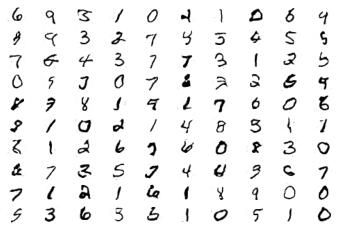

=> Saved: generated_plot_37480.png, model_37480.h5, and gan_model_37480.h5
> Step 37500: d_loss[0.522, 0.543], g[1.038] q[0.007]
> Step 37600: d_loss[0.626, 0.566], g[1.067] q[0.013]


2021-12-20 09:34:32.752170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:32.866686: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:33.070234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 37700: d_loss[0.692, 0.809], g[1.125] q[0.030]


2021-12-20 09:34:37.200775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:37.387169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:39.416436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:39.614904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:39.702404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:39.870341: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:40.051189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 37800: d_loss[0.681, 0.574], g[0.874] q[0.176]
> Step 37900: d_loss[0.949, 0.632], g[0.994] q[0.064]


2021-12-20 09:34:54.692778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:54.919445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:34:55.062991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 38000: d_loss[0.614, 0.749], g[1.174] q[0.021]
> Step 38100: d_loss[0.530, 0.530], g[1.137] q[0.008]
> Step 38200: d_loss[0.530, 0.667], g[1.060] q[0.007]


2021-12-20 09:35:11.060737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.207385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.241110: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.313923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.687023: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.731429: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.930030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:11.992026: W tensorflow/core/data/root_dataset.cc:16

> Step 38300: d_loss[0.647, 0.642], g[1.109] q[0.026]
> Step 38400: d_loss[0.698, 0.572], g[1.145] q[0.025]
> Step 38500: d_loss[0.651, 0.513], g[0.777] q[0.075]
> Step 38600: d_loss[0.727, 0.707], g[0.984] q[0.028]


2021-12-20 09:35:43.822875: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:44.164715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:44.212127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:44.323513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:44.372725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 38700: d_loss[0.580, 0.366], g[0.782] q[0.011]


2021-12-20 09:35:49.690002: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:35:50.165211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 38800: d_loss[0.502, 0.787], g[1.294] q[0.032]
> Step 38900: d_loss[0.435, 0.476], g[1.313] q[0.002]


2021-12-20 09:36:00.944520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39000: d_loss[0.992, 0.482], g[1.113] q[0.031]


2021-12-20 09:36:11.638919: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:11.684328: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:12.040391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:12.075510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39100: d_loss[0.433, 0.499], g[1.330] q[0.086]


2021-12-20 09:36:15.769768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:16.124465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:16.741935: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39200: d_loss[0.255, 0.482], g[1.424] q[0.008]


2021-12-20 09:36:22.949521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:22.982658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39300: d_loss[0.629, 0.522], g[1.213] q[0.024]
> Step 39400: d_loss[1.170, 0.535], g[1.422] q[0.019]


2021-12-20 09:36:33.577641: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:33.618394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39500: d_loss[0.363, 0.410], g[0.472] q[0.066]


2021-12-20 09:36:44.865497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:45.073579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39600: d_loss[0.397, 0.570], g[1.468] q[0.016]


2021-12-20 09:36:47.948991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:47.985105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:48.044078: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:48.140172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:36:48.614513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 39700: d_loss[1.470, 0.418], g[1.172] q[0.066]
> Step 39800: d_loss[0.679, 0.622], g[1.128] q[0.061]
> Step 39900: d_loss[0.647, 0.727], g[1.629] q[0.058]
> Step 40000: d_loss[0.739, 0.417], g[1.284] q[0.002]
> Step 40100: d_loss[0.820, 0.418], g[1.125] q[0.017]


2021-12-20 09:37:20.858433: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:20.925386: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:21.028205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:21.063955: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:21.120803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:21.153848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:21.212160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:21.244994: W tensorflow/core/data/root_dataset.cc:16

> Step 40200: d_loss[0.865, 0.224], g[1.251] q[0.002]


2021-12-20 09:37:28.683306: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 40300: d_loss[0.784, 0.595], g[1.309] q[0.003]
> Step 40400: d_loss[0.816, 1.084], g[0.854] q[0.034]
> Step 40500: d_loss[0.549, 0.587], g[1.187] q[0.005]


2021-12-20 09:37:50.909860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:51.169142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 40600: d_loss[0.460, 0.445], g[1.857] q[0.040]


2021-12-20 09:37:52.943347: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.003895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.038033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.223242: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.310846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.499579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.594370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:37:53.678966: W tensorflow/core/data/root_dataset.cc:16

> Step 40700: d_loss[0.483, 0.596], g[1.729] q[0.004]


2021-12-20 09:38:01.586710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:01.820525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 40800: d_loss[0.677, 0.889], g[1.408] q[0.006]
> Step 40900: d_loss[0.486, 0.444], g[1.249] q[0.042]


2021-12-20 09:38:12.751527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:12.841219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:12.875492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 41000: d_loss[0.395, 0.408], g[1.272] q[0.025]


2021-12-20 09:38:25.002321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:25.144510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:25.203066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:25.237487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:25.302726: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:25.850516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 41100: d_loss[0.581, 0.510], g[1.132] q[0.034]
> Step 41200: d_loss[0.853, 0.482], g[1.573] q[0.006]


2021-12-20 09:38:35.010530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 41300: d_loss[0.420, 0.661], g[1.425] q[0.009]


2021-12-20 09:38:45.878793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 41400: d_loss[0.302, 0.441], g[1.208] q[0.008]
> Step 41500: d_loss[0.345, 0.586], g[1.139] q[0.011]


2021-12-20 09:38:56.685310: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:57.056900: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:57.332829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:57.851532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:58.307318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:58.340285: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:58.395397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:38:58.521861: W tensorflow/core/data/root_dataset.cc:16

> Step 41600: d_loss[0.709, 0.600], g[1.535] q[0.023]


2021-12-20 09:39:07.933142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 41700: d_loss[0.187, 0.683], g[1.742] q[0.037]
> Step 41800: d_loss[0.244, 0.488], g[1.283] q[0.010]


2021-12-20 09:39:18.887487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 41900: d_loss[0.658, 0.581], g[1.654] q[0.058]


2021-12-20 09:39:29.670609: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:39:29.917128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:39:30.846095: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42000: d_loss[0.779, 0.604], g[1.001] q[0.001]
> Step 42100: d_loss[0.489, 0.213], g[1.610] q[0.103]


2021-12-20 09:39:40.674947: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:39:40.739928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:39:40.989267: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42200: d_loss[0.334, 0.664], g[1.552] q[0.013]
> Step 42300: d_loss[0.138, 0.510], g[1.464] q[0.008]


2021-12-20 09:40:01.725868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:01.876927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:02.289522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:02.332847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42400: d_loss[0.371, 0.459], g[1.164] q[0.008]


2021-12-20 09:40:03.176429: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42500: d_loss[0.663, 0.477], g[1.261] q[0.008]


2021-12-20 09:40:13.968959: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42600: d_loss[0.273, 0.390], g[1.358] q[0.057]


2021-12-20 09:40:25.133519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42700: d_loss[0.900, 0.605], g[0.986] q[0.008]
> Step 42800: d_loss[0.851, 0.596], g[1.346] q[0.011]


2021-12-20 09:40:33.865349: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:33.961346: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:33.993979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:34.111977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:34.265546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:34.844130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:35.795504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 42900: d_loss[0.361, 0.477], g[1.244] q[0.001]


2021-12-20 09:40:46.679150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43000: d_loss[0.543, 0.332], g[1.564] q[0.033]
> Step 43100: d_loss[0.949, 0.371], g[0.918] q[0.110]


2021-12-20 09:40:57.811656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:57.906802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:40:57.999384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43200: d_loss[0.509, 0.641], g[1.113] q[0.024]


2021-12-20 09:41:07.055361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:07.090524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:07.191281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:07.244192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:07.271136: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:07.854016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43300: d_loss[0.710, 0.538], g[1.413] q[0.198]


2021-12-20 09:41:08.790822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:08.826807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:08.887461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:08.925277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:08.998602: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:09.032924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43400: d_loss[0.278, 0.548], g[1.259] q[0.054]


2021-12-20 09:41:20.115527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43500: d_loss[0.903, 0.461], g[0.592] q[0.017]
> Step 43600: d_loss[0.920, 0.707], g[1.088] q[0.047]


2021-12-20 09:41:30.582607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:30.909207: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43700: d_loss[0.782, 0.448], g[0.925] q[0.024]


2021-12-20 09:41:38.665454: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:39.491894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:41:42.095525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 43800: d_loss[0.457, 0.618], g[1.178] q[0.005]
> Step 43900: d_loss[0.526, 0.596], g[1.034] q[0.006]


2021-12-20 09:41:53.015161: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44000: d_loss[0.700, 1.008], g[0.742] q[0.010]


2021-12-20 09:42:03.924736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44100: d_loss[0.366, 0.308], g[1.409] q[0.014]


2021-12-20 09:42:10.591915: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:10.695925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:11.128523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:11.266318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:11.476506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44200: d_loss[0.506, 0.462], g[1.158] q[0.007]


2021-12-20 09:42:14.704638: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:14.866739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:14.993144: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:15.048103: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44300: d_loss[0.583, 0.449], g[1.007] q[0.101]
> Step 44400: d_loss[0.406, 0.609], g[1.523] q[0.015]


2021-12-20 09:42:25.729636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:26.029807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44500: d_loss[0.495, 0.482], g[1.263] q[0.037]
> Step 44600: d_loss[0.655, 0.490], g[1.074] q[0.033]


2021-12-20 09:42:43.044870: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:43.162007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:43.258506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:43.654755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:42:43.747509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44700: d_loss[0.792, 0.713], g[1.488] q[0.012]


2021-12-20 09:42:47.852521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 44800: d_loss[0.427, 0.514], g[1.278] q[0.159]
> Step 44900: d_loss[0.277, 0.572], g[1.077] q[0.028]


2021-12-20 09:42:59.028819: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45000: d_loss[0.709, 1.069], g[1.460] q[0.038]


2021-12-20 09:43:09.835651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:09.896256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45100: d_loss[1.141, 0.303], g[1.139] q[0.003]


2021-12-20 09:43:14.583480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:14.756404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:14.843389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:15.477794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:15.586522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:15.639842: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45200: d_loss[0.489, 0.630], g[0.985] q[0.025]


2021-12-20 09:43:20.821968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45300: d_loss[0.943, 0.654], g[1.191] q[0.010]


2021-12-20 09:43:31.636199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45400: d_loss[0.701, 0.555], g[0.828] q[0.052]
> Step 45500: d_loss[0.442, 0.657], g[1.338] q[0.003]


2021-12-20 09:43:42.814425: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45600: d_loss[0.564, 0.482], g[1.223] q[0.017]


2021-12-20 09:43:47.281948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:47.363821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:47.456867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:43:48.011594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45700: d_loss[0.765, 0.642], g[1.148] q[0.046]
> Step 45800: d_loss[0.492, 0.482], g[1.068] q[0.003]


2021-12-20 09:44:04.589188: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:04.884099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 45900: d_loss[0.634, 0.424], g[1.079] q[0.014]
> Step 46000: d_loss[0.894, 0.520], g[1.001] q[0.014]


2021-12-20 09:44:15.627722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:16.024508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:19.428327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:19.647522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:19.688605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 46100: d_loss[0.707, 0.366], g[1.259] q[0.010]


2021-12-20 09:44:26.581336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:26.675099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 46200: d_loss[0.858, 0.984], g[0.831] q[0.008]
> Step 46300: d_loss[0.809, 0.602], g[0.984] q[0.002]
> Step 46400: d_loss[0.822, 0.609], g[1.159] q[0.014]
> Step 46500: d_loss[0.797, 0.622], g[1.028] q[0.011]


2021-12-20 09:44:48.808213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:48.867907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:49.088460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:51.959539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:52.108589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:52.538495: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:52.588557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:44:52.737506: W tensorflow/core/data/root_dataset.cc:16

> Step 46600: d_loss[0.594, 0.591], g[1.104] q[0.011]


2021-12-20 09:44:59.737485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:00.094722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 46700: d_loss[0.509, 0.610], g[1.127] q[0.039]
> Step 46800: d_loss[0.653, 0.795], g[1.150] q[0.015]


2021-12-20 09:45:10.764196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


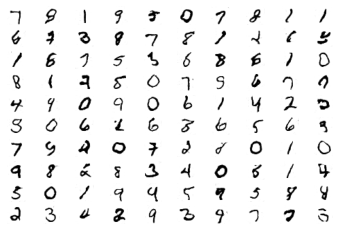

=> Saved: generated_plot_46850.png, model_46850.h5, and gan_model_46850.h5
> Step 46900: d_loss[0.587, 0.546], g[1.020] q[0.010]


2021-12-20 09:45:21.584339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:22.109512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:24.315230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:24.504810: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:24.919494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47000: d_loss[0.504, 0.902], g[1.284] q[0.003]


2021-12-20 09:45:25.231513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:25.308149: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47100: d_loss[0.826, 0.676], g[1.095] q[0.014]


2021-12-20 09:45:33.057387: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47200: d_loss[0.575, 0.931], g[1.197] q[0.002]


2021-12-20 09:45:43.810532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:44.632874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:44.677201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47300: d_loss[0.608, 0.611], g[1.166] q[0.004]
> Step 47400: d_loss[0.640, 0.535], g[1.167] q[0.002]


2021-12-20 09:45:54.792730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:45:57.464497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47500: d_loss[0.675, 0.694], g[1.048] q[0.014]


2021-12-20 09:46:05.724519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:05.890532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47600: d_loss[0.841, 0.659], g[0.933] q[0.013]
> Step 47700: d_loss[0.615, 0.720], g[1.061] q[0.017]


2021-12-20 09:46:16.795186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 47800: d_loss[0.948, 0.830], g[0.896] q[0.009]
> Step 47900: d_loss[0.695, 0.657], g[1.035] q[0.111]


2021-12-20 09:46:27.793453: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:27.969253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:30.978730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:31.068397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:31.224521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:31.322710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:31.370601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:46:31.627714: W tensorflow/core/data/root_dataset.cc:16

> Step 48000: d_loss[0.570, 0.743], g[1.033] q[0.082]


2021-12-20 09:46:38.755779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 48100: d_loss[0.560, 0.616], g[0.850] q[0.054]
> Step 48200: d_loss[0.734, 0.704], g[1.201] q[0.006]
> Step 48300: d_loss[0.757, 0.713], g[0.884] q[0.002]


2021-12-20 09:47:00.593796: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:00.936522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:00.996112: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:01.030895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 48400: d_loss[0.589, 0.726], g[0.957] q[0.029]


2021-12-20 09:47:03.328815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:03.388323: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:03.527200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:03.820640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 48500: d_loss[0.772, 0.701], g[0.985] q[0.011]


2021-12-20 09:47:11.585491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:11.778989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:11.812000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:11.873038: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:12.099199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 48600: d_loss[0.619, 0.793], g[0.899] q[0.079]


2021-12-20 09:47:22.958905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:22.994871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:23.054464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 48700: d_loss[0.775, 0.685], g[0.962] q[0.068]
> Step 48800: d_loss[0.840, 0.662], g[0.870] q[0.001]


2021-12-20 09:47:33.772438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:34.015632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:34.121936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:36.312701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:36.428631: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:36.468059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:36.763752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:47:36.850611: W tensorflow/core/data/root_dataset.cc:16

> Step 48900: d_loss[0.641, 0.773], g[0.968] q[0.010]
> Step 49000: d_loss[0.616, 0.674], g[0.964] q[0.001]


2021-12-20 09:47:45.125603: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 49100: d_loss[0.734, 0.561], g[0.898] q[0.003]
> Step 49200: d_loss[0.602, 0.649], g[1.021] q[0.025]
> Step 49300: d_loss[0.639, 0.627], g[0.983] q[0.001]


2021-12-20 09:48:05.767791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:06.741374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:06.780266: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:06.892861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:09.256568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:09.319575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:09.360062: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:09.717058: W tensorflow/core/data/root_dataset.cc:16

> Step 49400: d_loss[0.680, 0.661], g[0.985] q[0.029]
> Step 49500: d_loss[0.620, 0.793], g[0.947] q[0.002]
> Step 49600: d_loss[0.752, 0.512], g[0.956] q[0.021]
> Step 49700: d_loss[0.688, 0.837], g[0.855] q[0.000]


2021-12-20 09:48:39.610745: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:39.804486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:39.859508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:42.011478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:42.259672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:42.367570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:42.851172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 49800: d_loss[0.648, 0.699], g[0.853] q[0.031]
> Step 49900: d_loss[0.688, 0.673], g[0.797] q[0.005]


2021-12-20 09:48:50.916396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:51.026007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:48:51.089862: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 50000: d_loss[0.653, 0.636], g[0.838] q[0.118]


2021-12-20 09:49:01.726574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:01.838577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 50100: d_loss[0.631, 0.580], g[0.915] q[0.004]
> Step 50200: d_loss[0.717, 0.736], g[0.880] q[0.004]


2021-12-20 09:49:12.204311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:12.499518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:12.734540: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:14.007119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:14.098116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:14.131663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:14.189156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:14.553881: W tensorflow/core/data/root_dataset.cc:16

> Step 50300: d_loss[0.589, 0.676], g[0.853] q[0.012]
> Step 50400: d_loss[0.694, 0.732], g[0.850] q[0.003]
> Step 50500: d_loss[0.704, 0.808], g[0.867] q[0.016]


2021-12-20 09:49:35.100520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 50600: d_loss[0.597, 0.699], g[1.005] q[0.004]


2021-12-20 09:49:45.786315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:45.849825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:46.344485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:46.548521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:46.842713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:46.893599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:47.002515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:47.157609: W tensorflow/core/data/root_dataset.cc:16

> Step 50700: d_loss[0.691, 0.600], g[0.987] q[0.004]
> Step 50800: d_loss[0.754, 0.660], g[0.968] q[0.002]


2021-12-20 09:49:56.615179: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:56.731508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:49:56.834272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 50900: d_loss[0.629, 0.736], g[0.803] q[0.005]
> Step 51000: d_loss[0.547, 0.685], g[0.853] q[0.002]
> Step 51100: d_loss[0.580, 0.811], g[0.777] q[0.002]


2021-12-20 09:50:18.361503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 51200: d_loss[0.604, 0.702], g[0.895] q[0.041]


2021-12-20 09:50:29.780198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:29.819502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:30.019460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 51300: d_loss[0.692, 0.695], g[0.795] q[0.007]
> Step 51400: d_loss[0.657, 0.643], g[0.779] q[0.010]


2021-12-20 09:50:40.816894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 51500: d_loss[0.727, 0.815], g[0.830] q[0.015]


2021-12-20 09:50:51.751008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 51600: d_loss[0.600, 0.701], g[0.850] q[0.002]


2021-12-20 09:50:58.542193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:58.753964: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:58.855625: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:58.892361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:58.957543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:58.992049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:59.325961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:50:59.422836: W tensorflow/core/data/root_dataset.cc:16

> Step 51700: d_loss[0.710, 0.731], g[0.885] q[0.002]
> Step 51800: d_loss[0.608, 0.661], g[0.847] q[0.035]
> Step 51900: d_loss[0.679, 0.781], g[0.920] q[0.009]


2021-12-20 09:51:24.584057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 52000: d_loss[0.632, 0.703], g[0.903] q[0.009]


2021-12-20 09:51:24.894703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:25.082272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:25.163583: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:25.201530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:25.324582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:30.996196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:31.141539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:31.442329: W tensorflow/core/data/root_dataset.cc:16

> Step 52100: d_loss[0.745, 0.745], g[0.889] q[0.003]


2021-12-20 09:51:35.912462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:36.109850: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 52200: d_loss[0.697, 0.686], g[0.766] q[0.004]
> Step 52300: d_loss[0.723, 0.657], g[0.883] q[0.125]
> Step 52400: d_loss[0.646, 0.746], g[0.919] q[0.007]


2021-12-20 09:51:57.902675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:57.939287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:58.556752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:58.691978: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:51:58.726749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 52500: d_loss[0.753, 0.641], g[0.996] q[0.005]
> Step 52600: d_loss[0.741, 0.694], g[0.815] q[0.086]


2021-12-20 09:52:08.624321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.194762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.400509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.592579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.726774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.778224: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.811073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:10.897417: W tensorflow/core/data/root_dataset.cc:16

> Step 52700: d_loss[0.623, 0.689], g[1.059] q[0.020]


2021-12-20 09:52:19.988996: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 52800: d_loss[0.662, 0.573], g[0.909] q[0.031]
> Step 52900: d_loss[0.718, 0.800], g[0.862] q[0.002]


2021-12-20 09:52:30.637983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:31.461509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 53000: d_loss[0.630, 0.653], g[0.977] q[0.080]
> Step 53100: d_loss[0.601, 0.768], g[0.958] q[0.040]


2021-12-20 09:52:42.726308: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:42.790773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:42.891925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:43.415287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:52:43.449548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 53200: d_loss[0.771, 0.640], g[0.907] q[0.008]


2021-12-20 09:52:53.168591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 53300: d_loss[0.641, 0.637], g[0.905] q[0.275]
> Step 53400: d_loss[0.737, 0.797], g[0.936] q[0.009]


2021-12-20 09:53:04.242054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 53500: d_loss[0.654, 0.654], g[1.042] q[0.019]


2021-12-20 09:53:14.833646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:15.522613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:15.616029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:15.650027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:15.706292: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:15.739960: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:16.018821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:16.105880: W tensorflow/core/data/root_dataset.cc:16

> Step 53600: d_loss[0.670, 0.614], g[0.990] q[0.004]
> Step 53700: d_loss[0.726, 0.752], g[0.916] q[0.003]


2021-12-20 09:53:25.861512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 53800: d_loss[0.617, 0.668], g[0.860] q[0.035]


2021-12-20 09:53:36.747115: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:37.231749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:37.376518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 53900: d_loss[0.665, 0.586], g[0.962] q[0.039]
> Step 54000: d_loss[0.645, 0.610], g[0.887] q[0.014]


2021-12-20 09:53:48.592158: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:48.716689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:49.051033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:49.083491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:49.168396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:49.319304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:49.405814: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:49.438601: W tensorflow/core/data/root_dataset.cc:16

> Step 54100: d_loss[0.583, 0.742], g[0.969] q[0.002]


2021-12-20 09:53:58.827090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:53:58.894463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 54200: d_loss[0.666, 0.703], g[1.019] q[0.002]
> Step 54300: d_loss[0.701, 0.771], g[0.889] q[0.003]


2021-12-20 09:54:09.893526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:10.125532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:10.196727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 54400: d_loss[0.619, 0.610], g[0.911] q[0.064]
> Step 54500: d_loss[0.616, 0.603], g[0.849] q[0.015]


2021-12-20 09:54:20.859162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:21.687601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:21.886875: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:21.973445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:22.096214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:22.186189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:22.236680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:22.321929: W tensorflow/core/data/root_dataset.cc:16

> Step 54600: d_loss[0.785, 0.687], g[0.822] q[0.184]


2021-12-20 09:54:31.586009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 54700: d_loss[0.610, 0.628], g[1.041] q[0.044]
> Step 54800: d_loss[0.862, 0.626], g[0.945] q[0.122]
> Step 54900: d_loss[0.743, 0.743], g[1.000] q[0.003]


2021-12-20 09:54:47.939844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:53.832203: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:53.866082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:53.937203: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 55000: d_loss[0.892, 0.788], g[1.159] q[0.004]


2021-12-20 09:54:54.995757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.028653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.084064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.117270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.206074: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.300502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.350855: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:54:55.385131: W tensorflow/core/data/root_dataset.cc:16

> Step 55100: d_loss[0.763, 0.658], g[0.991] q[0.085]
> Step 55200: d_loss[0.575, 0.664], g[1.309] q[0.126]


2021-12-20 09:55:15.803958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:15.866385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 55300: d_loss[0.698, 0.662], g[1.241] q[0.004]
> Step 55400: d_loss[0.672, 0.491], g[1.016] q[0.035]


2021-12-20 09:55:23.198293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:26.999664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:27.078082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:27.112779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:27.612727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:27.690996: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:27.729337: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:27.923805: W tensorflow/core/data/root_dataset.cc:16

> Step 55500: d_loss[0.523, 0.756], g[1.115] q[0.036]
> Step 55600: d_loss[0.586, 0.571], g[0.840] q[0.012]
> Step 55700: d_loss[0.606, 0.785], g[1.021] q[0.031]


2021-12-20 09:55:48.584543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:55:48.678821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 55800: d_loss[0.639, 0.535], g[0.955] q[0.002]
> Step 55900: d_loss[0.423, 0.815], g[1.270] q[0.030]


2021-12-20 09:56:00.202141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:00.591582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:01.135359: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:01.170951: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:01.231703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 56000: d_loss[0.412, 0.787], g[1.082] q[0.059]


2021-12-20 09:56:01.339553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:10.579986: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:11.038821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 56100: d_loss[0.634, 0.897], g[1.041] q[0.014]
> Step 56200: d_loss[0.637, 0.557], g[1.252] q[0.180]


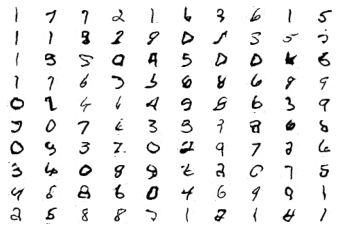

=> Saved: generated_plot_56220.png, model_56220.h5, and gan_model_56220.h5
> Step 56300: d_loss[0.647, 0.623], g[1.020] q[0.068]


2021-12-20 09:56:34.003815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 56400: d_loss[0.688, 0.585], g[1.033] q[0.004]


2021-12-20 09:56:43.746125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:43.781932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:43.836133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 56500: d_loss[0.519, 0.596], g[1.129] q[0.053]
> Step 56600: d_loss[0.517, 0.330], g[1.531] q[0.003]


2021-12-20 09:56:54.718773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:54.773005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:54.809419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:54.901539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:56:55.056513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 56700: d_loss[0.915, 0.632], g[1.327] q[0.269]


2021-12-20 09:57:05.781927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:05.821449: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:05.889261: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:06.004198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:06.438533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:07.187725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:07.219685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:07.366451: W tensorflow/core/data/root_dataset.cc:16

> Step 56800: d_loss[0.774, 0.856], g[1.449] q[0.153]
> Step 56900: d_loss[0.481, 0.746], g[1.456] q[0.034]


2021-12-20 09:57:16.649050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:16.760183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 57000: d_loss[0.695, 0.593], g[1.193] q[0.025]


2021-12-20 09:57:27.611444: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:27.889907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:28.079509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 57100: d_loss[0.809, 0.617], g[1.495] q[0.045]
> Step 57200: d_loss[0.505, 0.840], g[1.222] q[0.007]


2021-12-20 09:57:38.834162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:39.452455: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:39.574649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:40.359567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:40.541957: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:40.580069: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:40.778639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:40.885799: W tensorflow/core/data/root_dataset.cc:16

> Step 57300: d_loss[0.268, 0.478], g[1.389] q[0.010]
> Step 57400: d_loss[0.583, 0.804], g[1.190] q[0.106]


2021-12-20 09:57:49.581226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:57:50.126557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 57500: d_loss[0.227, 0.618], g[1.213] q[0.024]


2021-12-20 09:58:00.735644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:00.774589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:00.840589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:00.978989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 57600: d_loss[0.502, 0.357], g[1.122] q[0.052]
> Step 57700: d_loss[0.607, 0.687], g[1.535] q[0.067]


2021-12-20 09:58:10.504530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:10.801826: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:11.760315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:11.804610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:12.085616: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:12.565714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:12.978967: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 57800: d_loss[0.321, 0.411], g[1.649] q[0.017]


2021-12-20 09:58:22.806686: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:22.863934: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 57900: d_loss[0.456, 0.408], g[1.243] q[0.092]
> Step 58000: d_loss[0.733, 0.800], g[2.216] q[0.084]


2021-12-20 09:58:34.130191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 58100: d_loss[0.160, 0.945], g[1.835] q[0.016]


2021-12-20 09:58:44.381452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:44.471343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:44.612380: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:45.096569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:45.313532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:45.555047: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 58200: d_loss[0.830, 0.871], g[1.095] q[0.035]
> Step 58300: d_loss[0.095, 0.840], g[2.182] q[0.023]


2021-12-20 09:58:55.613420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:55.910935: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:56.036066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:58:56.139565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 58400: d_loss[0.851, 0.782], g[1.678] q[0.001]
> Step 58500: d_loss[1.037, 0.945], g[1.785] q[0.001]


2021-12-20 09:59:06.961829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:07.086908: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 58600: d_loss[0.246, 0.190], g[1.887] q[0.013]


2021-12-20 09:59:17.179014: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:17.232017: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:17.323654: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:18.164529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:18.460945: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:18.508505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 58700: d_loss[0.383, 0.707], g[1.983] q[0.044]
> Step 58800: d_loss[1.016, 0.640], g[1.056] q[0.029]


2021-12-20 09:59:28.719619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:28.778344: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 58900: d_loss[0.483, 0.219], g[1.698] q[0.003]


2021-12-20 09:59:39.752264: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:39.813412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:39.998761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 59000: d_loss[0.598, 0.465], g[1.649] q[0.040]
> Step 59100: d_loss[0.161, 0.574], g[2.218] q[0.033]
> Step 59200: d_loss[0.521, 0.489], g[1.927] q[0.022]


2021-12-20 09:59:54.664526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:54.973564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:55.067076: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:55.232900: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:55.275161: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:55.391545: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:55.587434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 09:59:55.671854: W tensorflow/core/data/root_dataset.cc:16

> Step 59300: d_loss[0.389, 0.474], g[1.840] q[0.006]


2021-12-20 10:00:01.757412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:01.814824: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:01.907084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 59400: d_loss[0.543, 0.500], g[1.019] q[0.043]


2021-12-20 10:00:12.836230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 59500: d_loss[1.391, 0.458], g[1.054] q[0.067]
> Step 59600: d_loss[0.332, 0.320], g[1.000] q[0.002]


2021-12-20 10:00:23.687419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:27.433393: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:27.838713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:28.112513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:28.158713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:28.272719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:28.322709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:28.459511: W tensorflow/core/data/root_dataset.cc:16

> Step 59700: d_loss[0.851, 0.264], g[1.460] q[0.060]


2021-12-20 10:00:34.566547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:34.812163: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 59800: d_loss[0.713, 0.626], g[1.620] q[0.011]
> Step 59900: d_loss[0.287, 0.511], g[1.400] q[0.030]


2021-12-20 10:00:45.846310: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:46.103367: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 60000: d_loss[0.317, 0.180], g[1.409] q[0.010]
> Step 60100: d_loss[0.275, 0.686], g[1.969] q[0.148]


2021-12-20 10:00:59.623048: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:59.686049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:59.783739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:00:59.917509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:00.310526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 60200: d_loss[0.535, 0.700], g[1.297] q[0.074]
> Step 60300: d_loss[0.681, 0.444], g[1.382] q[0.142]


2021-12-20 10:01:18.696665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:18.813798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 60400: d_loss[0.661, 1.024], g[1.995] q[0.007]
> Step 60500: d_loss[1.061, 0.622], g[1.633] q[0.007]


2021-12-20 10:01:29.799026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:29.922523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:32.463166: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:32.629133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:32.783200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:32.898248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:32.937624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:33.304551: W tensorflow/core/data/root_dataset.cc:16

> Step 60600: d_loss[0.737, 0.199], g[1.038] q[0.145]


2021-12-20 10:01:40.670795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:41.013525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:01:41.047947: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 60700: d_loss[1.591, 0.111], g[1.290] q[0.015]
> Step 60800: d_loss[0.314, 0.256], g[1.807] q[0.041]


2021-12-20 10:01:51.795119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 60900: d_loss[0.504, 0.090], g[2.245] q[0.070]
> Step 61000: d_loss[1.577, 0.637], g[1.300] q[0.007]


2021-12-20 10:02:02.906517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:02.939506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:03.132830: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:04.642682: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:04.803702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:04.861395: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 61100: d_loss[0.462, 1.330], g[1.218] q[0.039]
> Step 61200: d_loss[0.968, 1.156], g[1.728] q[0.005]
> Step 61300: d_loss[0.703, 0.295], g[1.141] q[0.018]
> Step 61400: d_loss[0.153, 0.517], g[1.257] q[0.007]


2021-12-20 10:02:35.575033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:36.011869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:36.485513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:36.760558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:37.078484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:37.118174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:37.208632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:37.313619: W tensorflow/core/data/root_dataset.cc:16

> Step 61500: d_loss[0.162, 0.414], g[1.842] q[0.098]


2021-12-20 10:02:46.853515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:02:47.080527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 61600: d_loss[0.337, 0.362], g[1.642] q[0.010]
> Step 61700: d_loss[0.659, 0.795], g[0.814] q[0.026]
> Step 61800: d_loss[0.343, 0.169], g[1.258] q[0.003]


2021-12-20 10:03:08.546390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:08.592186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:09.067901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:09.475779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:09.524552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:09.633854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:09.677051: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 61900: d_loss[0.849, 0.617], g[0.954] q[0.001]
> Step 62000: d_loss[1.016, 0.446], g[1.746] q[0.002]


2021-12-20 10:03:19.810450: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 62100: d_loss[0.418, 0.525], g[1.973] q[0.090]
> Step 62200: d_loss[0.274, 0.506], g[1.099] q[0.012]
> Step 62300: d_loss[0.327, 0.151], g[1.334] q[0.032]


2021-12-20 10:03:40.349914: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:03:40.692364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 62400: d_loss[1.250, 0.541], g[1.373] q[0.006]
> Step 62500: d_loss[0.312, 0.265], g[1.790] q[0.006]
> Step 62600: d_loss[0.213, 0.780], g[1.936] q[0.016]


2021-12-20 10:04:03.883970: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 62700: d_loss[0.446, 0.942], g[0.814] q[0.026]


2021-12-20 10:04:12.644999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:12.739508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:13.376280: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:13.413148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:14.577137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 62800: d_loss[0.905, 0.833], g[0.698] q[0.034]
> Step 62900: d_loss[0.625, 0.294], g[1.258] q[0.012]


2021-12-20 10:04:26.003525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:26.067591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63000: d_loss[0.244, 0.407], g[0.692] q[0.012]


2021-12-20 10:04:36.622520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:36.726714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63100: d_loss[0.151, 0.143], g[1.358] q[0.005]


2021-12-20 10:04:44.526637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:45.021583: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:45.125533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:45.184514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63200: d_loss[0.981, 0.445], g[1.307] q[0.019]
> Step 63300: d_loss[0.178, 0.473], g[1.509] q[0.009]


2021-12-20 10:04:58.669924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:58.783078: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:58.821227: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:58.883521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:04:59.173681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63400: d_loss[0.598, 0.114], g[1.874] q[0.014]
> Step 63500: d_loss[0.580, 0.904], g[1.658] q[0.008]


2021-12-20 10:05:09.632351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:09.791748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63600: d_loss[0.211, 0.601], g[1.799] q[0.033]


2021-12-20 10:05:16.508101: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:16.624767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:16.682240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:16.722525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:17.275556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:17.468034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63700: d_loss[0.312, 0.918], g[1.923] q[0.073]


2021-12-20 10:05:20.995295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:21.119771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63800: d_loss[0.093, 0.359], g[1.481] q[0.118]


2021-12-20 10:05:31.626915: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 63900: d_loss[0.194, 0.367], g[2.100] q[0.147]
> Step 64000: d_loss[0.845, 0.501], g[1.772] q[0.003]


2021-12-20 10:05:43.091503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 64100: d_loss[0.622, 0.492], g[1.105] q[0.017]


2021-12-20 10:05:48.402373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:48.691517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:48.791509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:49.195558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:49.490539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:05:53.640136: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 64200: d_loss[0.421, 0.699], g[1.381] q[0.011]
> Step 64300: d_loss[0.447, 0.520], g[0.842] q[0.003]


2021-12-20 10:06:04.677464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:04.717586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 64400: d_loss[0.607, 0.645], g[1.950] q[0.022]
> Step 64500: d_loss[1.093, 1.073], g[0.709] q[0.044]


2021-12-20 10:06:15.650998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:15.971698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:16.101703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:18.568506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:20.404494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:20.911418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 64600: d_loss[0.940, 0.860], g[1.380] q[0.073]


2021-12-20 10:06:26.805324: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:26.903526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:27.115133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 64700: d_loss[0.872, 0.502], g[1.543] q[0.003]
> Step 64800: d_loss[0.597, 0.248], g[0.879] q[0.024]


2021-12-20 10:06:37.794961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:37.880243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:37.917529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 64900: d_loss[0.538, 0.591], g[1.769] q[0.082]
> Step 65000: d_loss[0.221, 0.873], g[2.170] q[0.005]


2021-12-20 10:06:52.566950: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:52.777063: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:53.167707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:06:53.220399: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 65100: d_loss[0.127, 0.234], g[1.253] q[0.092]


2021-12-20 10:06:59.840228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 65200: d_loss[0.306, 0.740], g[1.850] q[0.051]
> Step 65300: d_loss[0.258, 0.269], g[2.497] q[0.003]
> Step 65400: d_loss[0.617, 0.392], g[1.187] q[0.071]
> Step 65500: d_loss[0.662, 0.545], g[1.284] q[0.003]


2021-12-20 10:07:23.848524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.297517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.417017: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.570363: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.624269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.659830: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.717274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:24.964936: W tensorflow/core/data/root_dataset.cc:16

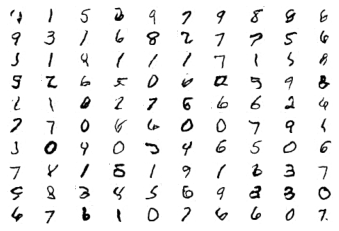

=> Saved: generated_plot_65590.png, model_65590.h5, and gan_model_65590.h5
> Step 65600: d_loss[0.366, 0.371], g[1.467] q[0.005]
> Step 65700: d_loss[0.884, 0.368], g[1.963] q[0.084]


2021-12-20 10:07:43.859512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 65800: d_loss[1.003, 0.602], g[0.741] q[0.195]
> Step 65900: d_loss[0.269, 0.666], g[1.262] q[0.040]


2021-12-20 10:07:54.869751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:56.427797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:56.843401: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:07:56.965095: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 66000: d_loss[0.150, 0.424], g[1.529] q[0.003]


2021-12-20 10:08:05.778524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:06.111363: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 66100: d_loss[0.372, 0.485], g[2.792] q[0.022]
> Step 66200: d_loss[0.176, 0.293], g[2.560] q[0.041]


2021-12-20 10:08:16.955525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:17.010559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:17.136853: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 66300: d_loss[0.686, 0.358], g[1.948] q[0.052]


2021-12-20 10:08:27.717525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:27.856267: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:28.082508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:28.128686: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:28.268498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:28.436544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:28.612599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:28.687961: W tensorflow/core/data/root_dataset.cc:16

> Step 66400: d_loss[0.313, 0.281], g[1.443] q[0.010]
> Step 66500: d_loss[0.044, 0.346], g[2.259] q[0.026]
> Step 66600: d_loss[0.187, 1.138], g[0.866] q[0.007]
> Step 66700: d_loss[0.338, 0.559], g[1.370] q[0.005]


2021-12-20 10:08:49.750422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:49.804550: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:49.837763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:49.892272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:08:50.024342: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 66800: d_loss[0.443, 0.955], g[2.859] q[0.057]


2021-12-20 10:09:00.651702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:01.191957: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 66900: d_loss[1.174, 1.200], g[1.505] q[0.018]
> Step 67000: d_loss[0.813, 0.566], g[1.064] q[0.033]


2021-12-20 10:09:11.645743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:11.812566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 67100: d_loss[0.335, 1.087], g[1.184] q[0.005]


2021-12-20 10:09:22.805390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:22.893303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 67200: d_loss[0.316, 0.328], g[1.160] q[0.010]
> Step 67300: d_loss[0.237, 0.355], g[1.668] q[0.004]


2021-12-20 10:09:34.224924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:34.678560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:34.833592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:34.875713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:34.971510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:35.030538: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:35.065507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 67400: d_loss[0.320, 0.989], g[2.617] q[0.002]


2021-12-20 10:09:44.745832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:09:45.140643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 67500: d_loss[0.441, 0.178], g[2.225] q[0.019]
> Step 67600: d_loss[0.301, 0.074], g[2.560] q[0.023]
> Step 67700: d_loss[0.590, 0.281], g[1.741] q[0.016]
> Step 67800: d_loss[0.118, 0.286], g[2.075] q[0.002]


2021-12-20 10:10:07.122110: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:07.447479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:07.666714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:07.709176: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:07.814516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:07.855680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 67900: d_loss[0.057, 0.338], g[1.838] q[0.035]


2021-12-20 10:10:17.732073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68000: d_loss[0.528, 0.437], g[1.530] q[0.029]
> Step 68100: d_loss[0.138, 0.861], g[1.761] q[0.082]


2021-12-20 10:10:28.597354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:28.740767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68200: d_loss[1.572, 0.608], g[1.478] q[0.004]


2021-12-20 10:10:40.538526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:40.973503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:10:41.083748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68300: d_loss[0.435, 0.249], g[0.959] q[0.012]
> Step 68400: d_loss[0.492, 0.914], g[0.553] q[0.087]


2021-12-20 10:10:50.789702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68500: d_loss[0.292, 0.195], g[1.812] q[0.057]


2021-12-20 10:11:01.770253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68600: d_loss[0.378, 0.461], g[1.865] q[0.088]
> Step 68700: d_loss[0.462, 0.818], g[2.081] q[0.038]


2021-12-20 10:11:12.526589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68800: d_loss[0.599, 0.334], g[1.441] q[0.020]


2021-12-20 10:11:18.566920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:24.061723: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:24.097988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 68900: d_loss[0.826, 0.177], g[1.040] q[0.022]


2021-12-20 10:11:28.570022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 69000: d_loss[0.325, 1.231], g[1.881] q[0.272]


2021-12-20 10:11:34.674789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:34.861102: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:34.896516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:35.103577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 69100: d_loss[0.910, 0.729], g[1.341] q[0.003]
> Step 69200: d_loss[0.608, 0.352], g[0.998] q[0.004]


2021-12-20 10:11:47.499560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:49.873343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:49.979736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:50.086318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:50.227581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:50.337959: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:50.395237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:11:50.519415: W tensorflow/core/data/root_dataset.cc:16

> Step 69300: d_loss[0.054, 0.874], g[2.033] q[0.034]
> Step 69400: d_loss[0.170, 1.017], g[1.195] q[0.017]
> Step 69500: d_loss[1.075, 0.650], g[2.017] q[0.056]
> Step 69600: d_loss[0.583, 0.186], g[1.573] q[0.005]


2021-12-20 10:12:18.966638: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:19.032081: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:19.248192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:19.403096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:19.534517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:23.282404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:23.371787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 69700: d_loss[0.080, 0.238], g[2.720] q[0.039]


2021-12-20 10:12:23.566693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:23.719485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:23.816842: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:23.910322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:24.000190: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:24.095573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:30.109445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 69800: d_loss[0.805, 0.139], g[2.070] q[0.053]
> Step 69900: d_loss[0.400, 0.263], g[1.932] q[0.005]


2021-12-20 10:12:40.752586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:41.011526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70000: d_loss[0.081, 1.406], g[3.037] q[0.008]


2021-12-20 10:12:51.830105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:51.950489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:52.060021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:52.163789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70100: d_loss[0.421, 0.204], g[2.136] q[0.116]


2021-12-20 10:12:56.286339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:56.378800: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:56.660421: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:56.694705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:56.836480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:12:56.878282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70200: d_loss[0.922, 0.284], g[0.649] q[0.023]


2021-12-20 10:13:02.851310: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:03.048521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70300: d_loss[0.305, 0.198], g[1.968] q[0.086]
> Step 70400: d_loss[0.699, 0.319], g[0.724] q[0.004]
> Step 70500: d_loss[0.098, 0.548], g[1.795] q[0.012]


2021-12-20 10:13:25.021534: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:25.623516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70600: d_loss[0.431, 0.416], g[2.077] q[0.005]


2021-12-20 10:13:28.564746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:29.103586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:29.318240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:29.463137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:29.498484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:29.659603: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:29.748368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70700: d_loss[0.343, 0.734], g[1.699] q[0.008]


2021-12-20 10:13:38.562276: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70800: d_loss[0.158, 0.679], g[1.930] q[0.037]


2021-12-20 10:13:46.618080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 70900: d_loss[0.850, 0.693], g[1.940] q[0.196]
> Step 71000: d_loss[1.055, 0.809], g[2.098] q[0.010]


2021-12-20 10:13:57.743452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:57.941516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:58.167731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:13:58.202997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:01.053404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:01.141217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:01.235879: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:01.272202: W tensorflow/core/data/root_dataset.cc:16

> Step 71100: d_loss[0.251, 0.461], g[1.488] q[0.017]
> Step 71200: d_loss[0.871, 0.720], g[1.593] q[0.079]
> Step 71300: d_loss[0.122, 0.451], g[1.726] q[0.152]


2021-12-20 10:14:19.827523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 71400: d_loss[0.175, 0.154], g[1.049] q[0.052]


2021-12-20 10:14:31.050521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:33.269765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 71500: d_loss[0.561, 0.410], g[1.178] q[0.097]


2021-12-20 10:14:33.688245: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:33.855460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:33.887347: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:33.986083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:34.040724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:34.074934: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 71600: d_loss[0.020, 0.273], g[1.815] q[0.055]


2021-12-20 10:14:41.905502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 71700: d_loss[1.308, 0.151], g[1.359] q[0.027]


2021-12-20 10:14:52.697764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:14:53.096520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 71800: d_loss[0.154, 0.127], g[1.307] q[0.027]
> Step 71900: d_loss[0.509, 0.285], g[1.061] q[0.026]


2021-12-20 10:15:03.670863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:04.565519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:04.941409: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:05.356456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:05.577724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:05.610491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 72000: d_loss[0.365, 0.898], g[0.736] q[0.024]
> Step 72100: d_loss[0.833, 0.455], g[1.483] q[0.050]
> Step 72200: d_loss[0.366, 0.394], g[1.565] q[0.013]


2021-12-20 10:15:25.862486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 72300: d_loss[0.170, 0.404], g[1.413] q[0.003]
> Step 72400: d_loss[0.124, 0.292], g[2.514] q[0.018]


2021-12-20 10:15:36.771644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:36.811327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:37.070621: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:37.787143: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 72500: d_loss[0.315, 0.352], g[1.163] q[0.022]


2021-12-20 10:15:47.975529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 72600: d_loss[0.812, 0.498], g[1.893] q[0.010]
> Step 72700: d_loss[0.352, 0.356], g[1.765] q[0.050]


2021-12-20 10:15:58.780184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:58.875855: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:58.908521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:15:58.963516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 72800: d_loss[0.345, 0.443], g[2.364] q[0.010]
> Step 72900: d_loss[0.202, 0.095], g[2.004] q[0.005]


2021-12-20 10:16:08.614048: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:09.430452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:09.572505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:09.588394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:09.750127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:09.986439: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 73000: d_loss[0.314, 0.559], g[1.659] q[0.015]


2021-12-20 10:16:20.621001: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:20.749590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:21.117983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 73100: d_loss[0.216, 0.241], g[2.077] q[0.047]
> Step 73200: d_loss[0.902, 0.212], g[0.922] q[0.023]


2021-12-20 10:16:31.718868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:31.791522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:32.077522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 73300: d_loss[0.985, 0.693], g[1.169] q[0.008]


2021-12-20 10:16:40.883089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:40.943857: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:41.043529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:41.393716: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:41.436665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:41.540715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:41.716704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:41.763528: W tensorflow/core/data/root_dataset.cc:16

> Step 73400: d_loss[0.580, 0.785], g[1.439] q[0.035]
> Step 73500: d_loss[0.128, 0.436], g[1.738] q[0.024]


2021-12-20 10:16:53.877526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:16:53.997220: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 73600: d_loss[1.138, 0.989], g[2.241] q[0.014]
> Step 73700: d_loss[0.261, 0.245], g[1.968] q[0.002]


2021-12-20 10:17:04.708041: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:04.986150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 73800: d_loss[0.334, 0.360], g[2.845] q[0.003]


2021-12-20 10:17:12.779865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:12.934753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:13.051088: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:13.103744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:13.271710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:13.418512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:13.699703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:13.783492: W tensorflow/core/data/root_dataset.cc:16

> Step 73900: d_loss[0.754, 1.402], g[1.743] q[0.042]
> Step 74000: d_loss[0.318, 0.579], g[1.942] q[0.057]


2021-12-20 10:17:26.780075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:26.843132: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:26.877818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 74100: d_loss[0.315, 0.279], g[1.509] q[0.009]


2021-12-20 10:17:37.809910: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 74200: d_loss[0.568, 0.889], g[1.471] q[0.010]


2021-12-20 10:17:45.191191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:45.249478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:45.350194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:45.481868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:45.509664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:45.523716: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:45.609846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:17:46.115732: W tensorflow/core/data/root_dataset.cc:16

> Step 74300: d_loss[0.152, 1.136], g[1.444] q[0.007]


2021-12-20 10:17:46.391600: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 74400: d_loss[0.512, 0.492], g[1.705] q[0.004]
> Step 74500: d_loss[0.513, 0.279], g[1.853] q[0.022]
> Step 74600: d_loss[0.756, 0.730], g[1.999] q[0.004]


2021-12-20 10:18:11.117509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 74700: d_loss[0.140, 0.425], g[1.588] q[0.015]


2021-12-20 10:18:16.857740: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:17.039077: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:17.072567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:18.035928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:18.239401: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:21.753791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 74800: d_loss[0.138, 1.042], g[1.360] q[0.076]
> Step 74900: d_loss[0.506, 1.033], g[1.439] q[0.002]


2021-12-20 10:18:32.745478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:32.781207: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


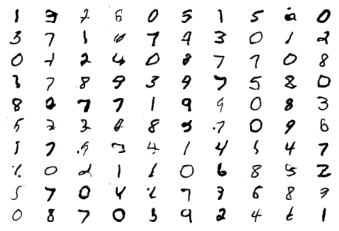

=> Saved: generated_plot_74960.png, model_74960.h5, and gan_model_74960.h5
> Step 75000: d_loss[0.767, 1.113], g[1.715] q[0.050]


2021-12-20 10:18:43.834523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:44.037513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75100: d_loss[0.484, 1.276], g[1.146] q[0.032]


2021-12-20 10:18:49.800827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:49.887251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:49.922117: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:49.976640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:50.318655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:50.388333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75200: d_loss[0.791, 0.441], g[1.701] q[0.031]


2021-12-20 10:18:54.772414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:54.995786: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:18:55.051759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75300: d_loss[0.537, 0.429], g[1.738] q[0.020]


2021-12-20 10:19:05.919130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:06.008880: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:06.101442: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75400: d_loss[0.805, 0.376], g[1.035] q[0.054]


2021-12-20 10:19:09.656115: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75500: d_loss[0.523, 0.640], g[2.467] q[0.032]


2021-12-20 10:19:16.834952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:17.022926: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75600: d_loss[0.526, 0.132], g[1.707] q[0.003]


2021-12-20 10:19:21.247527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:21.877542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:22.307863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:22.468169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:22.563676: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:22.648328: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:22.732858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75700: d_loss[0.500, 0.186], g[1.876] q[0.001]
> Step 75800: d_loss[0.199, 0.544], g[2.064] q[0.015]


2021-12-20 10:19:38.654564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:38.703817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:39.048765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:39.147937: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 75900: d_loss[0.395, 0.321], g[1.709] q[0.004]
> Step 76000: d_loss[0.443, 0.259], g[1.626] q[0.046]
> Step 76100: d_loss[0.740, 0.660], g[1.333] q[0.021]


2021-12-20 10:19:54.747578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:55.464830: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:55.565078: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:55.597458: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:55.709426: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:55.857821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:55.976800: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:19:56.028038: W tensorflow/core/data/root_dataset.cc:16

> Step 76200: d_loss[0.674, 1.222], g[1.047] q[0.021]


2021-12-20 10:20:01.080989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 76300: d_loss[0.305, 0.622], g[1.196] q[0.011]


2021-12-20 10:20:11.670993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:11.770692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:11.954881: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 76400: d_loss[0.751, 1.193], g[0.494] q[0.027]
> Step 76500: d_loss[1.553, 0.186], g[1.868] q[0.206]


2021-12-20 10:20:27.841105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:27.964493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:28.018998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:28.871422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 76600: d_loss[0.245, 0.355], g[1.865] q[0.041]


2021-12-20 10:20:33.882508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:34.057187: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 76700: d_loss[0.405, 0.215], g[1.411] q[0.065]
> Step 76800: d_loss[0.121, 0.265], g[1.828] q[0.002]


2021-12-20 10:20:45.110530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 76900: d_loss[0.346, 0.388], g[2.300] q[0.034]
> Step 77000: d_loss[0.138, 0.704], g[1.813] q[0.139]


2021-12-20 10:20:55.582052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:55.629388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:55.924229: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:20:59.870602: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:00.058642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:00.422528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:00.564737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:00.851747: W tensorflow/core/data/root_dataset.cc:16

> Step 77100: d_loss[0.718, 0.524], g[1.482] q[0.017]


2021-12-20 10:21:06.929510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:07.104503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 77200: d_loss[0.372, 0.204], g[1.289] q[0.022]
> Step 77300: d_loss[0.436, 0.536], g[1.221] q[0.007]


2021-12-20 10:21:17.795435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:17.876995: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 77400: d_loss[0.716, 1.028], g[1.163] q[0.001]


2021-12-20 10:21:28.729524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:28.970825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:29.057441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 77500: d_loss[0.616, 0.385], g[1.027] q[0.002]


2021-12-20 10:21:31.903984: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:32.115237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:32.411848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:32.605305: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:33.068528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 77600: d_loss[0.268, 0.635], g[2.935] q[0.013]
> Step 77700: d_loss[0.224, 0.766], g[1.788] q[0.009]


2021-12-20 10:21:50.715936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:50.907939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:21:51.054756: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 77800: d_loss[0.504, 0.502], g[1.151] q[0.030]
> Step 77900: d_loss[1.003, 0.475], g[1.495] q[0.005]


2021-12-20 10:22:01.626463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:03.849717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:03.952836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:04.040793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:04.093513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:04.227563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:04.690449: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:04.932527: W tensorflow/core/data/root_dataset.cc:16

> Step 78000: d_loss[0.614, 0.549], g[0.986] q[0.007]
> Step 78100: d_loss[1.033, 0.915], g[1.188] q[0.019]


2021-12-20 10:22:12.745654: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:12.783225: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:12.847064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 78200: d_loss[0.834, 0.295], g[1.389] q[0.087]


2021-12-20 10:22:24.093511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 78300: d_loss[0.333, 0.549], g[1.189] q[0.015]
> Step 78400: d_loss[0.498, 0.553], g[1.895] q[0.032]


2021-12-20 10:22:34.736549: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:36.082590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:36.266673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:36.301520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:36.527530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:36.911370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:37.032715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:37.284520: W tensorflow/core/data/root_dataset.cc:16

> Step 78500: d_loss[0.551, 0.836], g[0.679] q[0.009]


2021-12-20 10:22:45.764162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:45.800195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 78600: d_loss[0.252, 0.431], g[0.982] q[0.008]
> Step 78700: d_loss[0.464, 0.358], g[1.384] q[0.002]


2021-12-20 10:22:57.022673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:57.114742: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:22:58.562073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 78800: d_loss[0.557, 0.285], g[2.279] q[0.022]


2021-12-20 10:23:07.608852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:07.914513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:08.535289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:08.697056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:09.271973: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:09.306615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 78900: d_loss[1.058, 0.716], g[1.030] q[0.002]
> Step 79000: d_loss[0.298, 0.627], g[2.450] q[0.007]


2021-12-20 10:23:18.932956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:19.025073: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 79100: d_loss[0.435, 0.468], g[1.052] q[0.047]


2021-12-20 10:23:29.750502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:29.788300: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 79200: d_loss[1.175, 0.708], g[0.681] q[0.026]
> Step 79300: d_loss[0.413, 0.350], g[1.387] q[0.001]


2021-12-20 10:23:39.822963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:39.858057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:40.027194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:40.451714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:40.689509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:40.909605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:23:41.472192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 79400: d_loss[0.577, 0.663], g[1.463] q[0.001]
> Step 79500: d_loss[0.444, 0.732], g[1.777] q[0.021]
> Step 79600: d_loss[0.244, 1.034], g[1.167] q[0.012]


2021-12-20 10:24:02.590528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:02.859510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 79700: d_loss[1.070, 0.577], g[0.976] q[0.010]


2021-12-20 10:24:12.156191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:12.248400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:12.282086: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:12.346262: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:12.379858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:13.141507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:13.761706: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 79800: d_loss[0.379, 0.285], g[1.301] q[0.012]
> Step 79900: d_loss[0.710, 0.889], g[1.404] q[0.036]


2021-12-20 10:24:24.784611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:24.821361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:24.933407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80000: d_loss[0.742, 0.150], g[1.323] q[0.001]


2021-12-20 10:24:35.639223: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80100: d_loss[0.637, 0.607], g[1.269] q[0.061]


2021-12-20 10:24:43.658950: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:44.157716: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:44.416709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:44.459513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:44.574671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:44.621516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80200: d_loss[0.476, 0.524], g[1.226] q[0.066]


2021-12-20 10:24:45.074128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80300: d_loss[0.852, 1.081], g[0.665] q[0.005]


2021-12-20 10:24:57.634000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:58.028516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:24:58.090521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80400: d_loss[0.553, 0.359], g[1.287] q[0.005]
> Step 80500: d_loss[0.396, 0.937], g[1.549] q[0.004]


2021-12-20 10:25:08.831709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:09.050643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:09.122965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80600: d_loss[0.528, 0.549], g[0.894] q[0.002]


2021-12-20 10:25:15.801162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:15.999939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:16.519952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:19.824772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80700: d_loss[0.513, 0.491], g[1.376] q[0.010]
> Step 80800: d_loss[0.676, 0.545], g[1.704] q[0.075]


2021-12-20 10:25:30.697595: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:31.113669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 80900: d_loss[0.562, 0.652], g[2.211] q[0.003]


2021-12-20 10:25:41.686779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:41.752737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:41.790058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:42.096072: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 81000: d_loss[0.348, 0.930], g[1.254] q[0.006]


2021-12-20 10:25:48.103160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 81100: d_loss[0.626, 0.602], g[1.916] q[0.002]


2021-12-20 10:25:52.852461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:52.990052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:25:53.100093: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 81200: d_loss[0.750, 0.810], g[1.160] q[0.066]
> Step 81300: d_loss[0.724, 1.003], g[0.983] q[0.047]
> Step 81400: d_loss[0.512, 0.839], g[0.820] q[0.116]


2021-12-20 10:26:14.701774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:14.863978: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:15.136531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 81500: d_loss[0.494, 0.392], g[0.786] q[0.013]


2021-12-20 10:26:20.130141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:20.167988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:20.226624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:20.262165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:20.391522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:20.629796: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:20.778456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:21.088511: W tensorflow/core/data/root_dataset.cc:16

> Step 81600: d_loss[0.903, 0.896], g[1.136] q[0.042]
> Step 81700: d_loss[0.296, 0.671], g[1.671] q[0.014]
> Step 81800: d_loss[0.342, 0.574], g[1.224] q[0.003]


2021-12-20 10:26:48.075187: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 81900: d_loss[0.748, 0.491], g[1.652] q[0.059]


2021-12-20 10:26:52.221973: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:52.260731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:52.424136: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:52.464445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:53.275047: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:26:53.344369: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 82000: d_loss[0.376, 1.293], g[1.402] q[0.016]
> Step 82100: d_loss[0.376, 0.482], g[1.769] q[0.042]
> Step 82200: d_loss[0.681, 0.299], g[0.920] q[0.014]


2021-12-20 10:27:09.756118: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:09.816636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:10.079189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 82300: d_loss[0.318, 0.783], g[1.244] q[0.036]


2021-12-20 10:27:21.066527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 82400: d_loss[0.422, 1.194], g[2.089] q[0.005]


2021-12-20 10:27:24.191293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:24.275134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:24.375565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:24.715820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:24.877784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 82500: d_loss[0.770, 1.093], g[0.983] q[0.078]


2021-12-20 10:27:31.689818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:31.975522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 82600: d_loss[0.362, 0.423], g[1.259] q[0.019]
> Step 82700: d_loss[0.949, 0.722], g[1.461] q[0.075]
> Step 82800: d_loss[0.848, 0.436], g[1.428] q[0.013]


2021-12-20 10:27:53.767333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:55.834852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:55.966396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:56.017484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:27:56.463382: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 82900: d_loss[0.414, 0.625], g[1.950] q[0.108]
> Step 83000: d_loss[0.978, 0.807], g[0.802] q[0.056]


2021-12-20 10:28:05.136315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 83100: d_loss[0.487, 0.374], g[1.398] q[0.005]


2021-12-20 10:28:15.804725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:16.038277: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 83200: d_loss[0.225, 0.896], g[0.839] q[0.031]
> Step 83300: d_loss[0.952, 0.429], g[1.249] q[0.033]


2021-12-20 10:28:26.627087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:26.925624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:27.127362: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:27.898590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:27.949568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:28.207524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:28.368717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:28.418504: W tensorflow/core/data/root_dataset.cc:16

> Step 83400: d_loss[0.721, 0.449], g[1.727] q[0.001]
> Step 83500: d_loss[1.684, 0.657], g[0.837] q[0.001]
> Step 83600: d_loss[0.660, 0.434], g[1.156] q[0.002]


2021-12-20 10:28:48.871217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:49.102446: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 83700: d_loss[0.369, 0.641], g[1.458] q[0.006]
> Step 83800: d_loss[0.479, 0.605], g[0.888] q[0.044]


2021-12-20 10:28:59.149254: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:59.654365: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:59.699244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:59.801531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:59.835515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:59.891650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:28:59.925204: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:00.239990: W tensorflow/core/data/root_dataset.cc:16

> Step 83900: d_loss[0.397, 0.387], g[1.900] q[0.009]
> Step 84000: d_loss[1.149, 0.415], g[1.208] q[0.011]
> Step 84100: d_loss[0.659, 0.652], g[1.320] q[0.006]


2021-12-20 10:29:22.072515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84200: d_loss[1.069, 0.496], g[0.909] q[0.068]


2021-12-20 10:29:32.193258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:32.279536: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:32.362222: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84300: d_loss[1.073, 0.479], g[1.034] q[0.069]


2021-12-20 10:29:33.027643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:33.669515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:33.758548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


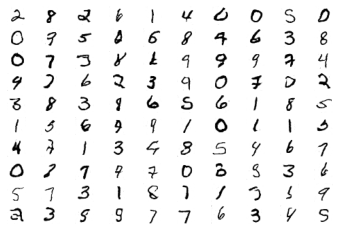

=> Saved: generated_plot_84330.png, model_84330.h5, and gan_model_84330.h5
> Step 84400: d_loss[0.745, 0.605], g[1.840] q[0.002]


2021-12-20 10:29:43.965869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84500: d_loss[0.862, 0.627], g[1.457] q[0.046]


2021-12-20 10:29:54.585579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:54.786681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:29:54.827022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84600: d_loss[0.465, 0.627], g[0.704] q[0.015]


2021-12-20 10:30:03.798626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:04.443705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:04.733202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:04.930283: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84700: d_loss[0.501, 0.758], g[1.176] q[0.004]


2021-12-20 10:30:06.085646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:09.604535: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84800: d_loss[0.502, 0.306], g[1.510] q[0.018]


2021-12-20 10:30:17.049795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 84900: d_loss[0.538, 0.588], g[1.285] q[0.003]
> Step 85000: d_loss[0.319, 0.579], g[1.251] q[0.037]
> Step 85100: d_loss[0.575, 0.951], g[1.483] q[0.027]


2021-12-20 10:30:35.573952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:35.666549: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:36.209428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:36.352004: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:37.034518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:38.560916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 85200: d_loss[0.163, 1.286], g[1.515] q[0.003]
> Step 85300: d_loss[0.165, 0.549], g[1.438] q[0.013]


2021-12-20 10:30:49.587867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:30:49.928327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 85400: d_loss[0.779, 0.590], g[0.902] q[0.007]
> Step 85500: d_loss[0.364, 0.490], g[1.849] q[0.004]


2021-12-20 10:31:00.631351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 85600: d_loss[0.211, 0.491], g[1.186] q[0.006]


2021-12-20 10:31:07.997906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:08.032949: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:08.237506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:08.503384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:08.553332: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:08.718651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:08.796506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:11.721611: W tensorflow/core/data/root_dataset.cc:16

> Step 85700: d_loss[0.557, 1.046], g[1.211] q[0.009]
> Step 85800: d_loss[0.828, 0.578], g[1.342] q[0.032]
> Step 85900: d_loss[0.421, 0.906], g[1.387] q[0.022]


2021-12-20 10:31:33.688906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:33.931777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:33.986445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:34.082515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 86000: d_loss[0.263, 0.271], g[1.320] q[0.133]


2021-12-20 10:31:40.083250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:40.419097: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:40.468504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:40.563505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:40.608727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:40.727511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:41.042979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 86100: d_loss[0.343, 0.394], g[1.728] q[0.009]


2021-12-20 10:31:44.898946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:31:45.069525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 86200: d_loss[0.681, 0.640], g[1.018] q[0.000]
> Step 86300: d_loss[0.682, 0.379], g[0.994] q[0.010]
> Step 86400: d_loss[1.493, 0.259], g[1.165] q[0.020]
> Step 86500: d_loss[0.147, 0.519], g[2.011] q[0.037]


2021-12-20 10:32:12.267768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:12.512064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:12.567013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:13.230330: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:18.032525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 86600: d_loss[0.316, 0.191], g[1.815] q[0.010]
> Step 86700: d_loss[1.110, 0.595], g[0.727] q[0.008]


2021-12-20 10:32:28.631958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:28.819029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 86800: d_loss[1.205, 0.368], g[0.867] q[0.041]
> Step 86900: d_loss[0.472, 0.479], g[1.221] q[0.009]


2021-12-20 10:32:43.856020: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:44.010384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:44.155923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:44.303598: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:44.691463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:45.220700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87000: d_loss[0.997, 0.718], g[0.810] q[0.068]


2021-12-20 10:32:50.923233: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:32:50.957846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87100: d_loss[0.491, 0.212], g[1.234] q[0.001]


2021-12-20 10:33:01.771992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:01.918928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87200: d_loss[0.395, 0.586], g[1.092] q[0.015]


2021-12-20 10:33:08.562582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87300: d_loss[0.258, 0.315], g[1.350] q[0.006]


2021-12-20 10:33:16.042610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:16.177166: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87400: d_loss[0.329, 0.438], g[0.802] q[0.002]


2021-12-20 10:33:17.439462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:17.508121: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:17.616510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87500: d_loss[0.399, 0.520], g[1.478] q[0.002]
> Step 87600: d_loss[1.138, 0.771], g[1.523] q[0.002]


2021-12-20 10:33:34.641242: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87700: d_loss[0.432, 0.586], g[1.860] q[0.036]


2021-12-20 10:33:45.717058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:45.916290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 87800: d_loss[0.618, 0.365], g[1.127] q[0.006]


2021-12-20 10:33:46.053831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:48.221768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:48.280066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:48.387104: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:48.422968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:48.912723: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:48.960596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:33:49.076714: W tensorflow/core/data/root_dataset.cc:16

> Step 87900: d_loss[0.219, 0.291], g[2.139] q[0.038]


2021-12-20 10:33:56.700127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 88000: d_loss[0.904, 0.398], g[1.807] q[0.013]
> Step 88100: d_loss[0.590, 0.957], g[1.312] q[0.050]


2021-12-20 10:34:07.984360: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 88200: d_loss[0.514, 1.131], g[1.539] q[0.014]


2021-12-20 10:34:19.018863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:19.636397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:19.869289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:19.916741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:20.033601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:21.049703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:21.265524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 88300: d_loss[0.557, 0.804], g[1.406] q[0.071]
> Step 88400: d_loss[1.089, 0.180], g[1.714] q[0.002]
> Step 88500: d_loss[0.613, 0.316], g[1.267] q[0.022]


2021-12-20 10:34:40.793177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:40.925195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 88600: d_loss[0.756, 0.425], g[1.582] q[0.009]
> Step 88700: d_loss[0.111, 0.989], g[1.381] q[0.006]


2021-12-20 10:34:52.198485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:52.353260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:52.400849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:52.852349: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:52.905521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:34:53.100516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 88800: d_loss[0.260, 0.558], g[2.117] q[0.015]
> Step 88900: d_loss[1.082, 0.843], g[1.063] q[0.008]
> Step 89000: d_loss[0.617, 0.206], g[1.291] q[0.001]
> Step 89100: d_loss[0.301, 0.541], g[1.080] q[0.008]


2021-12-20 10:35:24.026615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:24.159030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:24.451565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:24.664343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:25.048917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:25.253820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:25.331614: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:25.378513: W tensorflow/core/data/root_dataset.cc:16

> Step 89200: d_loss[0.415, 0.676], g[1.470] q[0.006]
> Step 89300: d_loss[0.617, 0.649], g[1.468] q[0.006]
> Step 89400: d_loss[0.623, 0.876], g[1.302] q[0.019]


2021-12-20 10:35:46.922000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:46.994044: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:47.033573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:48.567729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 89500: d_loss[0.561, 0.789], g[1.230] q[0.005]


2021-12-20 10:35:56.167119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.201749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.271174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.373110: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.456715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.577512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.626513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:35:56.741715: W tensorflow/core/data/root_dataset.cc:16

> Step 89600: d_loss[0.374, 0.624], g[1.100] q[0.001]
> Step 89700: d_loss[0.220, 0.636], g[1.055] q[0.002]


2021-12-20 10:36:08.765504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:08.934713: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 89800: d_loss[0.731, 0.714], g[1.941] q[0.109]


2021-12-20 10:36:19.589099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 89900: d_loss[0.747, 0.209], g[1.486] q[0.009]
> Step 90000: d_loss[0.375, 0.316], g[1.409] q[0.002]


2021-12-20 10:36:27.873544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:27.935305: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:27.972976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:28.646551: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:28.873021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:29.257817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:30.906335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 90100: d_loss[1.404, 0.490], g[1.230] q[0.009]
> Step 90200: d_loss[0.541, 0.442], g[1.500] q[0.020]


2021-12-20 10:36:41.893587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:36:42.016980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 90300: d_loss[0.538, 0.389], g[1.475] q[0.062]
> Step 90400: d_loss[0.351, 0.366], g[1.415] q[0.001]


2021-12-20 10:37:00.707617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:00.794871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:00.879689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:01.465750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:01.764562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 90500: d_loss[0.359, 0.569], g[1.784] q[0.010]
> Step 90600: d_loss[0.422, 0.380], g[1.151] q[0.032]


2021-12-20 10:37:15.088851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:15.122814: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 90700: d_loss[0.320, 0.284], g[1.626] q[0.073]
> Step 90800: d_loss[0.153, 0.443], g[0.937] q[0.005]


2021-12-20 10:37:25.735790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 90900: d_loss[0.321, 0.664], g[1.169] q[0.009]


2021-12-20 10:37:31.697345: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:31.809270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:31.916592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:32.149332: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:32.207515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:32.323719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:32.378592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:37:32.514726: W tensorflow/core/data/root_dataset.cc:16

> Step 91000: d_loss[0.399, 0.413], g[1.329] q[0.001]
> Step 91100: d_loss[0.725, 0.630], g[1.068] q[0.028]


2021-12-20 10:37:47.764341: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 91200: d_loss[0.359, 0.474], g[1.576] q[0.170]
> Step 91300: d_loss[0.514, 0.727], g[1.385] q[0.001]


2021-12-20 10:37:58.967386: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 91400: d_loss[0.393, 0.466], g[1.468] q[0.060]
> Step 91500: d_loss[0.332, 0.375], g[1.544] q[0.016]
> Step 91600: d_loss[0.578, 0.809], g[1.335] q[0.061]
> Step 91700: d_loss[0.592, 0.617], g[0.977] q[0.033]
> Step 91800: d_loss[1.356, 0.534], g[0.948] q[0.053]


2021-12-20 10:38:36.171530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:38:36.205574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:38:36.259797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:38:37.502112: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:38:37.595524: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 91900: d_loss[0.408, 0.755], g[0.815] q[0.024]


2021-12-20 10:38:42.755586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:38:42.789312: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 92000: d_loss[0.284, 0.682], g[0.802] q[0.003]
> Step 92100: d_loss[0.398, 0.553], g[1.480] q[0.017]
> Step 92200: d_loss[0.533, 0.399], g[1.128] q[0.023]


2021-12-20 10:39:04.739969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:04.844021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 92300: d_loss[0.991, 0.391], g[1.215] q[0.007]


2021-12-20 10:39:07.837156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:07.939395: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:08.025326: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:08.573396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 92400: d_loss[0.485, 0.561], g[0.905] q[0.043]
> Step 92500: d_loss[0.988, 1.024], g[1.103] q[0.020]
> Step 92600: d_loss[0.675, 0.436], g[1.562] q[0.026]


2021-12-20 10:39:26.620047: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:26.996988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:27.120530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 92700: d_loss[0.281, 0.601], g[1.216] q[0.055]


2021-12-20 10:39:37.585738: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:37.629425: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:38.144146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 92800: d_loss[0.604, 0.444], g[0.799] q[0.005]


2021-12-20 10:39:39.949511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:41.202207: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 92900: d_loss[0.753, 0.423], g[1.352] q[0.010]


2021-12-20 10:39:48.567154: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:48.668412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:39:48.780188: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 93000: d_loss[0.857, 0.288], g[1.238] q[0.002]
> Step 93100: d_loss[0.463, 0.570], g[1.510] q[0.011]
> Step 93200: d_loss[0.652, 0.596], g[1.649] q[0.061]


2021-12-20 10:40:10.936792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:40:11.780394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:40:11.915558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:40:12.231514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:40:12.554492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2021-12-20 10:40:12.723733: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 93300: d_loss[0.295, 0.753], g[1.047] q[0.110]


2021-12-20 10:40:21.585989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 93400: d_loss[0.895, 0.419], g[1.165] q[0.044]
> Step 93500: d_loss[0.686, 0.730], g[1.094] q[0.028]


2021-12-20 10:40:32.805057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


> Step 93600: d_loss[0.470, 0.653], g[1.143] q[0.021]
> Step 93700: d_loss[0.672, 0.711], g[1.119] q[0.001]


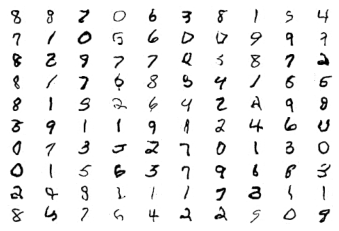

=> Saved: generated_plot_93700.png, model_93700.h5, and gan_model_93700.h5


In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_cat)